# EDA - HDB Resale

### Import Environment Modules and Data

In [137]:
### Import Python Modules

## System Modules
import sys
from typing import Union, Optional
import warnings

## Essential Modules
import numpy as np
import pandas as pd
from scipy.stats import randint
from scipy.stats import median_abs_deviation
import statsmodels.api as sm

## Graphical Modules
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

## Pipeline and Train Test Split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold
from sklearn.compose import ColumnTransformer

## SciKit Learning Preprocessing  
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, PowerTransformer
from sklearn.preprocessing import OneHotEncoder

### SciKit Learn ML Models

## Linear Models
from sklearn.linear_model import LinearRegression, HuberRegressor, QuantileRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.compose import TransformedTargetRegressor

## Tree Based Linear Models
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb


## Performance Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score


### Hyper-parameter Tuning

## GridSearch CV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score

## explicitly require this experimental feature
from sklearn.experimental import enable_halving_search_cv # noqa
# now you can import normally from model_selection
from sklearn.model_selection import HalvingGridSearchCV # type: ignore

## explicitly require this experimental feature
from sklearn.experimental import enable_halving_search_cv # noqa
# now you can import normally from model_selection
from sklearn.model_selection import HalvingRandomSearchCV # type: ignore

## Optuna for Hyperparameter Tuning
from optuna.integration import OptunaSearchCV
from optuna.distributions import IntDistribution, FloatDistribution


### Load Data

The following is a temporary placeholder. In a real end to end project, we need to connect to BigQuery and download the data from BigQuery using SQL extraction.

In [138]:
# Load the dataset
df = pd.read_csv('./data/ResaleflatpricesbasedonregistrationdatefromJan2017onwards.csv')

In [139]:
# give an indication on how large the dataset is
len(df)

209579

## Problem Statement

**We work for a property consultancy company. This company want to develop an end to end machine learning pipeline that could deliver housing price prediction to customer.**

**Our task is to develop a machine learning model that could accurately predict the resale prices of HDB resale flats. This model will assist buyers or sellers in planning their budgets more effectively and set realistic expectations. This model also need to help buyers determine the type of flat they can afford and in which location. This model also should provide sellers with valuable information regarding the potential market value of their property.**

## Basic Data Exploration

In [140]:
# Peek on the first 5 rows of the dataset
df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0


#### Detecting Duplicates

In [141]:
# check if there are any duplicates in the dataset
df.duplicated().sum()

np.int64(304)

**There are 304 duplicates.**

In [142]:
# Show the duplicates for visual inspection
df[df.duplicated(keep=False)].sort_values(by=list(df.columns))

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
224,2017-01,BUKIT MERAH,4 ROOM,106,HENDERSON CRES,07 TO 09,81.0,Improved,1975,57 years,470000.0
243,2017-01,BUKIT MERAH,4 ROOM,106,HENDERSON CRES,07 TO 09,81.0,Improved,1975,57 years,470000.0
304,2017-01,CENTRAL AREA,3 ROOM,271,QUEEN ST,16 TO 18,68.0,Improved,1979,61 years 02 months,470000.0
305,2017-01,CENTRAL AREA,3 ROOM,271,QUEEN ST,16 TO 18,68.0,Improved,1979,61 years 02 months,470000.0
505,2017-01,JURONG EAST,4 ROOM,265,TOH GUAN RD,04 TO 06,101.0,Model A,1998,80 years 09 months,470000.0
...,...,...,...,...,...,...,...,...,...,...,...
201242,2025-05,HOUGANG,4 ROOM,994C,BUANGKOK LINK,10 TO 12,93.0,Model A,2021,94 years 09 months,675000.0
209045,2025-05,YISHUN,4 ROOM,426B,YISHUN AVE 11,10 TO 12,92.0,Model A,2015,88 years 11 months,595000.0
209048,2025-05,YISHUN,4 ROOM,426B,YISHUN AVE 11,10 TO 12,92.0,Model A,2015,88 years 11 months,595000.0
204545,2025-06,SEMBAWANG,2 ROOM,103A,CANBERRA ST,04 TO 06,38.0,2-room,2020,94 years 07 months,350000.0


**There could be two possible reasons for duplications. The first reason is duplicate submission to the system. The second reason is there is a very slim possibility that there could be a similar sales at the same location, same type, within the same 3 storey range and sell at a same price.**

In [143]:
# compute the percentage of duplicates in the dataset
duplicates_percentage = df.duplicated().sum() / len(df) * 100
print(f'The number of duplicates is {df.duplicated().sum()}, which is {duplicates_percentage:.2f}% of the entire dataset. ')

The number of duplicates is 304, which is 0.15% of the entire dataset. 


**Since duplicated data is less than 1% of the entire dataset, we will remove the duplicates as it would not have impacted our analysis or prediction.**

In [144]:
# Remove duplicates
df = df.drop_duplicates()

In [145]:
# check if there are any duplicates in the dataset for confirmation
df.duplicated().sum()

np.int64(0)

#### Detecting Missing Values

In [146]:
# check if there are any missing values in the dataset
df.isnull().sum()

month                  0
town                   0
flat_type              0
block                  0
street_name            0
storey_range           0
floor_area_sqm         0
flat_model             0
lease_commence_date    0
remaining_lease        0
resale_price           0
dtype: int64

**No missing values.**

### Data Structure Analysis

In [147]:
# display the information and data structure of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 209275 entries, 0 to 209578
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   month                209275 non-null  object 
 1   town                 209275 non-null  object 
 2   flat_type            209275 non-null  object 
 3   block                209275 non-null  object 
 4   street_name          209275 non-null  object 
 5   storey_range         209275 non-null  object 
 6   floor_area_sqm       209275 non-null  float64
 7   flat_model           209275 non-null  object 
 8   lease_commence_date  209275 non-null  int64  
 9   remaining_lease      209275 non-null  object 
 10  resale_price         209275 non-null  float64
dtypes: float64(2), int64(1), object(8)
memory usage: 19.2+ MB


In [148]:
# Get numerical columns names and categorical columns names
numerical_columns = df.select_dtypes(include=['number']).columns
categorical_columns = df.select_dtypes(include=['object']).columns

# Print the numerical and categorical columns
print("Numerical columns:", numerical_columns)
print("Categorical columns:", categorical_columns)

Numerical columns: Index(['floor_area_sqm', 'lease_commence_date', 'resale_price'], dtype='object')
Categorical columns: Index(['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'flat_model', 'remaining_lease'],
      dtype='object')


#### Data Anomaly Analysis for Numerical Columns

In [149]:
# anomaly analysis for numerical columns
df[numerical_columns].describe()

,floor_area_sqm,lease_commence_date,resale_price
count,209275.000000,209275.000000,2.092750e+05
mean,96.870532,1996.322638,5.166457e+05
std,24.040256,14.235607,1.823789e+05
min,31.000000,1966.000000,1.400000e+05
25%,82.000000,1985.000000,3.800000e+05
50%,93.000000,1996.000000,4.850000e+05
75%,112.000000,2011.000000,6.200000e+05
max,366.700000,2022.000000,1.658888e+06


**There are no anaomaly, the minimum and maximum falls within expected range. For resale flat that has commencement date on 2022, there are some exception to the MOP rules especially for SERS holders.**

https://www.hdb.gov.sg/residential/living-in-an-hdb-flat/sers-and-upgrading-programmes/sers/sers-flat-owners/rehousing-options

#### Data Structure Anomaly Analysis for Categorical Columns

In [150]:
# check the unique values of the month column
df['month'].unique()

array(['2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06',
       '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12',
       '2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06',
       '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12',
       '2019-01', '2019-02', '2019-03', '2019-04', '2019-05', '2019-06',
       '2019-07', '2019-08', '2019-09', '2019-10', '2019-11', '2019-12',
       '2020-01', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06',
       '2020-07', '2020-08', '2020-09', '2020-10', '2020-11', '2020-12',
       '2021-01', '2021-02', '2021-03', '2021-04', '2021-05', '2021-06',
       '2021-07', '2021-08', '2021-09', '2021-10', '2021-11', '2021-12',
       '2022-01', '2022-02', '2022-03', '2022-04', '2022-05', '2022-06',
       '2022-07', '2022-08', '2022-09', '2022-10', '2022-11', '2022-12',
       '2023-01', '2023-02', '2023-03', '2023-04', '2023-05', '2023-06',
       '2023-07', '2023-08', '2023-09', '2023-10', 

**We can convert `month` to datetime format and convert it to year and month column. Then we set year as numeric and month as categorical.**

In [151]:
# check the unique values of the town column
df['town'].unique()

array(['ANG MO KIO', 'BEDOK', 'BISHAN', 'BUKIT BATOK', 'BUKIT MERAH',
       'BUKIT PANJANG', 'BUKIT TIMAH', 'CENTRAL AREA', 'CHOA CHU KANG',
       'CLEMENTI', 'GEYLANG', 'HOUGANG', 'JURONG EAST', 'JURONG WEST',
       'KALLANG/WHAMPOA', 'MARINE PARADE', 'PASIR RIS', 'PUNGGOL',
       'QUEENSTOWN', 'SEMBAWANG', 'SENGKANG', 'SERANGOON', 'TAMPINES',
       'TOA PAYOH', 'WOODLANDS', 'YISHUN'], dtype=object)

**We can use one-hot encoding for town.**

In [152]:
# check the unique values of the flat_type column
df['flat_type'].unique()

array(['2 ROOM', '3 ROOM', '4 ROOM', '5 ROOM', 'EXECUTIVE', '1 ROOM',
       'MULTI-GENERATION'], dtype=object)

**We can use ordinal encoding or one-hot encoding for flat_type.**

In [153]:
# check the unique values of the block column
df['block'].unique()

array(['406', '108', '602', ..., '479B', '479C', '478A'],
      shape=(2742,), dtype=object)

**We will use block number for future enhancement, for now we will remove them first.**

In [154]:
# check the unique values of the street_name column
df['street_name'].unique()

array(['ANG MO KIO AVE 10', 'ANG MO KIO AVE 4', 'ANG MO KIO AVE 5',
       'ANG MO KIO AVE 1', 'ANG MO KIO AVE 3', 'ANG MO KIO AVE 9',
       'ANG MO KIO AVE 8', 'ANG MO KIO AVE 6', 'ANG MO KIO ST 52',
       'BEDOK NTH AVE 4', 'BEDOK NTH AVE 1', 'BEDOK NTH RD',
       'BEDOK STH AVE 1', 'BEDOK RESERVOIR RD', 'CHAI CHEE ST',
       'BEDOK NTH ST 3', 'BEDOK STH RD', 'CHAI CHEE AVE',
       'NEW UPP CHANGI RD', 'CHAI CHEE DR', 'BEDOK STH AVE 2',
       'BEDOK NTH AVE 3', 'BEDOK RESERVOIR VIEW', 'CHAI CHEE RD',
       'LENGKONG TIGA', 'BEDOK CTRL', 'JLN DAMAI', 'BEDOK NTH AVE 2',
       'BEDOK STH AVE 3', 'SIN MING RD', 'SIN MING AVE', 'BISHAN ST 12',
       'BISHAN ST 13', 'BISHAN ST 22', 'BISHAN ST 24', 'BISHAN ST 23',
       'BRIGHT HILL DR', 'SHUNFU RD', 'BT BATOK ST 34', 'BT BATOK ST 51',
       'BT BATOK ST 11', 'BT BATOK ST 52', 'BT BATOK ST 21',
       'BT BATOK EAST AVE 5', 'BT BATOK WEST AVE 6', 'BT BATOK CTRL',
       'BT BATOK WEST AVE 8', 'BT BATOK EAST AVE 4', 'BT BATOK ST 3

**We will use street name for future enhancement, for now we will remove them first.**

In [155]:
# check the unique values of the storey_range column
df['storey_range'].unique()

array(['10 TO 12', '01 TO 03', '04 TO 06', '07 TO 09', '13 TO 15',
       '19 TO 21', '22 TO 24', '16 TO 18', '34 TO 36', '28 TO 30',
       '37 TO 39', '49 TO 51', '25 TO 27', '40 TO 42', '31 TO 33',
       '46 TO 48', '43 TO 45'], dtype=object)

**We can convert them to numerical number by taking the average between the 2 numbers.**

In [156]:
# check the unique values of the flat_model column
df['flat_model'].unique()

array(['Improved', 'New Generation', 'DBSS', 'Standard', 'Apartment',
       'Simplified', 'Model A', 'Premium Apartment', 'Adjoined flat',
       'Model A-Maisonette', 'Maisonette', 'Type S1', 'Type S2',
       'Model A2', 'Terrace', 'Improved-Maisonette', 'Premium Maisonette',
       'Multi Generation', 'Premium Apartment Loft', '2-room', '3Gen'],
      dtype=object)

**We can use one-hot encoding for `flat_model`.**

In [157]:
# check the unique values of the remaining_lease column
df['remaining_lease'].unique()

array(['61 years 04 months', '60 years 07 months', '62 years 05 months',
       '62 years 01 month', '63 years', '61 years 06 months',
       '58 years 04 months', '59 years 08 months', '59 years 06 months',
       '60 years', '62 years 08 months', '61 years', '60 years 10 months',
       '59 years 03 months', '61 years 05 months', '60 years 04 months',
       '62 years', '60 years 03 months', '63 years 09 months',
       '61 years 01 month', '61 years 10 months', '58 years 06 months',
       '59 years 04 months', '62 years 11 months', '60 years 08 months',
       '93 years 08 months', '93 years 07 months', '60 years 01 month',
       '94 years 08 months', '78 years 04 months', '60 years 06 months',
       '62 years 06 months', '58 years', '70 years 08 months',
       '63 years 04 months', '63 years 06 months', '67 years 07 months',
       '61 years 07 months', '68 years 02 months', '68 years 03 months',
       '56 years', '67 years 09 months', '67 years 05 months',
       '63 years 07

**We can convert remaining lease from years and months into numerical months only.**

## Data Cleaning

**There are no data cleaning or imputation required before target and feature analysis. However, we will drop location features as these are not in our scope of analysis.**

In [90]:
categorical_columns

Index(['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'flat_model', 'remaining_lease'],
      dtype='object')

In [91]:
# drop columns `block` and `street_name`
df = df.drop(columns=['block', 'street_name'])

In [92]:
# get numerical columns names
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns
numerical_columns

Index(['floor_area_sqm', 'lease_commence_date', 'resale_price'], dtype='object')

In [93]:
# get categorical columns names
categorical_columns = df.select_dtypes(include=['object']).columns
categorical_columns

Index(['month', 'town', 'flat_type', 'storey_range', 'flat_model',
       'remaining_lease'],
      dtype='object')

## Target Analysis

In [94]:
# Resale price Date Range
end = df['month'].max() 
start = df['month'].min()
print(f'The resale price data starts from {start} and end on {end}')

The resale price data starts from 2017-01 and end on 2025-06


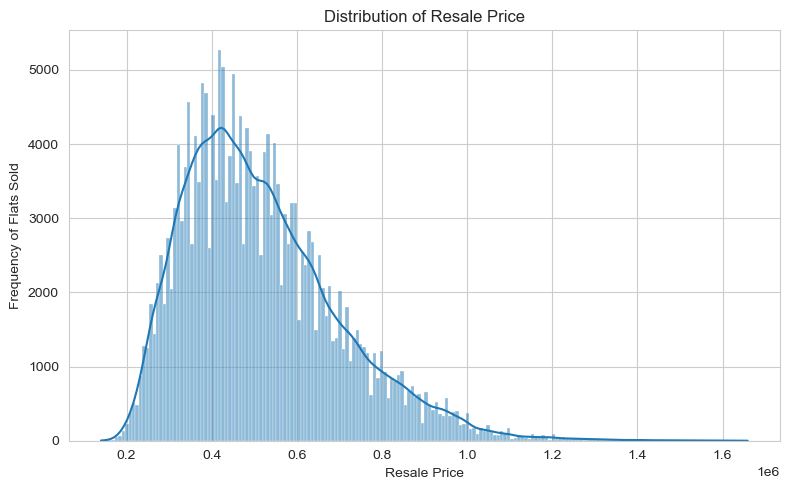

In [95]:
# Resale price distribution
fig, ax = plt.subplots(figsize=(8,5))  

sns.histplot(data=df, x='resale_price', kde=True, ax=ax)

ax.set_title('Distribution of Resale Price')
ax.set_xlabel('Resale Price')
ax.set_ylabel('Frequency of Flats Sold')

plt.tight_layout()
plt.show()

In [96]:
# display the statistical summary of the resale price
df['resale_price'].describe()

count    2.092750e+05
mean     5.166457e+05
std      1.823789e+05
min      1.400000e+05
25%      3.800000e+05
50%      4.850000e+05
75%      6.200000e+05
max      1.658888e+06
Name: resale_price, dtype: float64

In [97]:
# compute interquartile range of resale price
resale_price_iqr = df['resale_price'].quantile(0.75) - df['resale_price'].quantile(0.25)
resale_price_iqr

np.float64(240000.0)

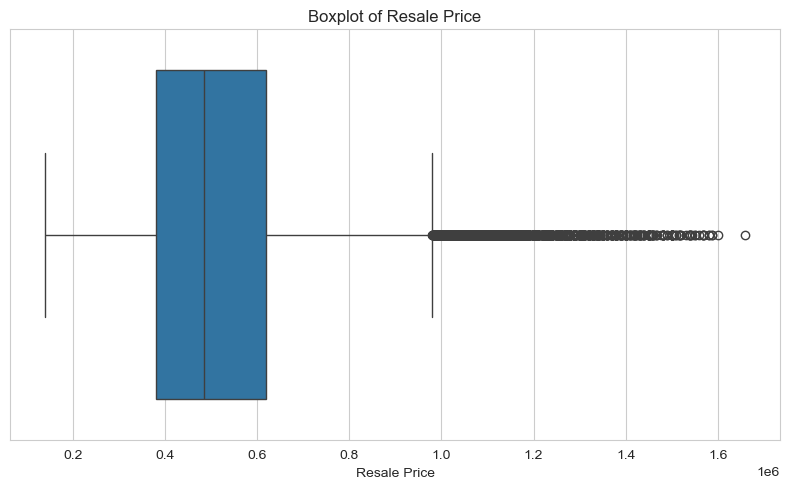

In [98]:
# boxplot the distribution of the resale price
fig, ax = plt.subplots(figsize=(8,5))  

sns.boxplot(data=df, x='resale_price', vert=False)

ax.set_title('Boxplot of Resale Price')
ax.set_xlabel('Resale Price')

plt.tight_layout()
plt.show()

**The mean resale price is approximately $516K, while the median is about $485K. Transaction prices range from roughly $140K to $1.65M. The distribution is slightly right-skewed, indicating a tail of higher-priced flats. Lower-priced units cluster more tightly around the median. A standard deviation of about $182K shows how much prices typically deviate from the mean. The interquartile range (middle 50 % of transactions) is roughly $240K.**

### Skewness Analysis

In [99]:
# Compute skewness of resale price
skewness = df['resale_price'].skew()
print(f"Skewness of Resale Price: {skewness:.2f}")
if skewness > 0.5: # type: ignore[arg-type]
    print("The distribution is positively skewed.")
elif skewness < -0.5: # type: ignore[arg-type]
    print("The distribution is negatively skewed.")
else:
    print("The distribution is approximately symmetric.")

# Compute kurtosis of resale price
kurtosis = df['resale_price'].kurt()
print(f"Kurtosis of Resale Price: {kurtosis:.2f}")
if kurtosis > 3: # type: ignore[arg-type]
    print("The distribution is leptokurtic.")
elif kurtosis < 3: # type: ignore[arg-type]
    print("The distribution is platykurtic.")
else:
    print("The distribution is mesokurtic.")

Skewness of Resale Price: 0.95
The distribution is positively skewed.
Kurtosis of Resale Price: 1.14
The distribution is platykurtic.


**Based on a skewness of 0.95, the HDB resale-price distribution is moderately right-skewed, indicating some high-price outliers are pulling the mean above the median. Although below 1.0, this skewness can still affect models that assume normal residuals, so we should check residual plots (e.g., residuals vs. fitted, Q–Q) and consider a log or Box–Cox transformation if needed.**

**With a kurtosis of 1.15 (< 3), the distribution is platykurtic, meaning it’s flatter-topped with thinner tails than a normal curve—there are less extreme values since the tail is thinner than those under Gaussian assumptions**

**Together, these measures reveal a fairly even spread of resale prices with a moderate right tail. For predictive modeling, we recommend running residual diagnostics and experimenting with a log(price) transform or robust regression techniques to ensure our assumptions hold.**

https://www.investopedia.com/terms/p/platykurtic.asp#:~:text=The%20term%20%22platykurtic%22%20refers%20to,extreme%20positive%20or%20negative%20events.

### Outliers Analysis

In [100]:
# outliers detection using IQR 
resale_price_iqr_q1 = df['resale_price'].quantile(0.25)
resale_price_iqr_q3 = df['resale_price'].quantile(0.75)

resale_price_iqr_outliers_left = df[(df['resale_price'] < resale_price_iqr_q1 - 1.5 * resale_price_iqr)]
print(f'The number of outliers (IQR) in the left distribution of resale price is {len(resale_price_iqr_outliers_left)}')
resale_price_iqr_outliers_right = df[(df['resale_price'] > resale_price_iqr_q3 + 1.5 * resale_price_iqr)]
print(f'The number of outliers (IQR) in the right distribution of resale price is {len(resale_price_iqr_outliers_right)}')

resale_price_iqr_outliers = pd.concat([resale_price_iqr_outliers_left,resale_price_iqr_outliers_right], ignore_index=True, axis=0)
print(f'The total number of outliers (IQR) in the resale price is {len(resale_price_iqr_outliers)}')

# percentage of outliers in the resale price
resale_price_iqr_outliers_percentage = len(resale_price_iqr_outliers) / len(df) * 100
print(f'Total number of transactions is {len(df)}')
print(f'The percentage of outliers (IQR) in the resale price is {resale_price_iqr_outliers_percentage:.2f}%')

The number of outliers (IQR) in the left distribution of resale price is 0
The number of outliers (IQR) in the right distribution of resale price is 3643
The total number of outliers (IQR) in the resale price is 3643
Total number of transactions is 209275
The percentage of outliers (IQR) in the resale price is 1.74%


In [101]:
# outliers detection using Z-score
resale_price_z_score = (df['resale_price'] - df['resale_price'].mean()) / df['resale_price'].std()
resale_price_z_score_threshold = 3
resale_price_z_score_outliers_left = df[resale_price_z_score < np.negative(resale_price_z_score_threshold)]
print(f'The number of outliers (z-score) in the left distribution of resale price is {len(resale_price_z_score_outliers_left)}')
resale_price_z_score_outliers_right = df[resale_price_z_score > resale_price_z_score_threshold]
print(f'The number of outliers (z-score) in the right distribution of resale price is {len(resale_price_z_score_outliers_right)}')

resale_price_z_score_outliers = pd.concat([resale_price_z_score_outliers_left, resale_price_z_score_outliers_right], axis=0, ignore_index=True)
print(f'The total number of outliers (z-score) in the resale price is {len(resale_price_z_score_outliers)}')

# percentage of outliers in the resale price
resale_price_z_score_outliers_percentage = len(resale_price_z_score_outliers) / len(df) * 100
print(f'Total number of transactions is {len(df)}')
print(f'The percentage of outliers (z-score) in the resale price is {resale_price_z_score_outliers_percentage:.2f}%')

The number of outliers (z-score) in the left distribution of resale price is 0
The number of outliers (z-score) in the right distribution of resale price is 1759
The total number of outliers (z-score) in the resale price is 1759
Total number of transactions is 209275
The percentage of outliers (z-score) in the resale price is 0.84%


**Using IQR method, there are 1.74% of transactions lie beyond 1.5 times of the third quartiles, so extreme HDB resale prices are fairly uncommon but not very rare.**

**Using z-score method, there are 0.84% of transactions lie beyond +3 $\sigma$. Compared to a Gaussian distribution, where 0.27% of data lies beyond ±3 σ, this 0.84% indicates a heavier right tail than expected under normal assumptions, suggesting the presence of significant high-value transactions, despite the overall platykurtic nature of the distribution (which implies thinner tails in general compared to a normal curve).** 

**The reason, z-score method detect less outliers because extreme values impacted its means and standard deviation. With elevated means and standard deviation, z-score method is only able to detect very extreme values. In a skewed distribution, the better method is using IQR method, as it is less sensitive to outliers. We will be adopting the percentage of outliers as 1.74% based on IQR method.**

In [102]:
# Descriptive statistics of outliers
print("Descriptive statistics of detected outliers:")
print(resale_price_iqr_outliers['resale_price'].describe())

Descriptive statistics of detected outliers:
count    3.643000e+03
mean     1.098834e+06
std      1.166179e+05
min      9.800880e+05
25%      1.010000e+06
50%      1.060000e+06
75%      1.150000e+06
max      1.658888e+06
Name: resale_price, dtype: float64


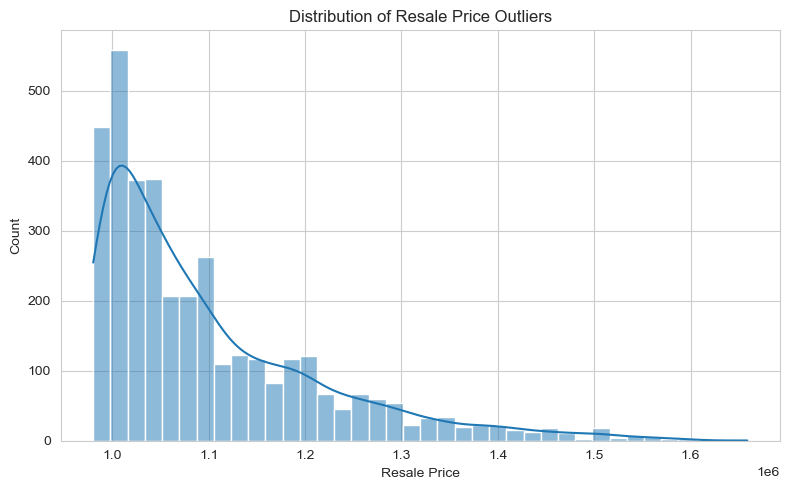

In [103]:
# plot the distribution of the outliers of resale price
fig, ax = plt.subplots(figsize=(8,5))  

sns.histplot(data=resale_price_iqr_outliers, x='resale_price', kde=True)


ax.set_title('Distribution of Resale Price Outliers')
ax.set_xlabel('Resale Price')

plt.tight_layout()
plt.show()

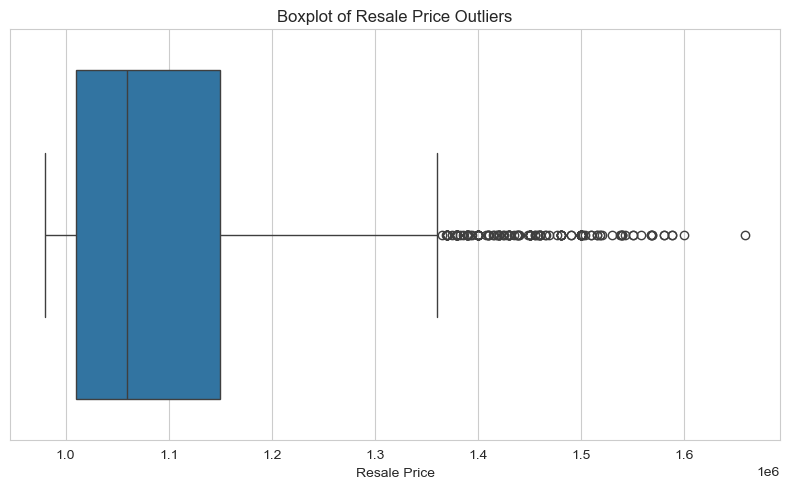

In [104]:
# boxplot the distribution of the outliers of resale price
fig, ax = plt.subplots(figsize=(8,5))  

sns.boxplot(data=resale_price_iqr_outliers, x='resale_price', vert=False)


ax.set_title('Boxplot of Resale Price Outliers')
ax.set_xlabel('Resale Price')

plt.tight_layout()
plt.show()

**Even among the 3,643 detected outliers, the distribution of resale prices is right-skewed (mean $1.098M vs. median $1.06M). This indicates that within this outlier segment, there are still a few significantly higher-value transactions that exert disproportional influence on this segment's mean and standard deviation.**

**These most extreme transactions within the outlier group are the ones that will have the greatest impact on the overall mean and standard deviation of the full HDB resale price dataset.** 

#### Million Dollar Flats by Year (Outliers in Layman Conext)

In [105]:
# Compute million dollars flats by year using a separate df
million_dollars_flats = df[df['resale_price'] >= 1000000].copy()
million_dollars_flats['month'] = pd.to_datetime(million_dollars_flats['month'])
million_dollars_flats['year'] = million_dollars_flats['month'].dt.year
million_dollars_flats_by_year = million_dollars_flats.groupby('year').size()
million_dollars_flats_by_year


year
2017      46
2018      71
2019      64
2020      82
2021     259
2022     369
2023     468
2024    1035
2025     738
dtype: int64

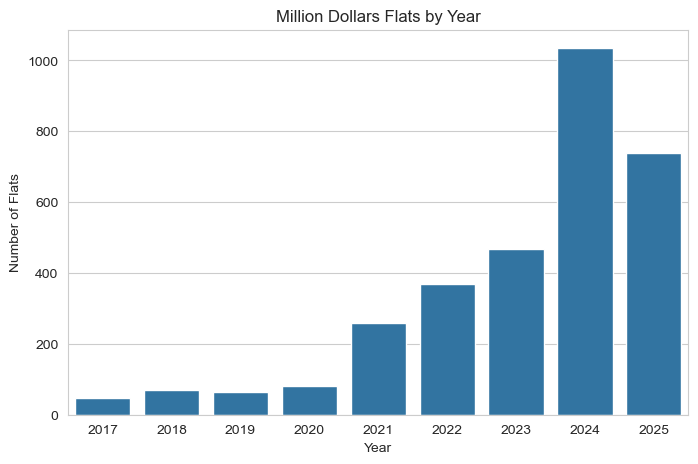

In [106]:
# plot the million dollars flats by year
plt.figure(figsize=(8,5))
sns.barplot(x=million_dollars_flats_by_year.index, y=million_dollars_flats_by_year.values)
plt.title('Million Dollars Flats by Year')
plt.xlabel('Year')
plt.ylabel('Number of Flats')
plt.show()  


In [107]:
million_dollars_flats.loc[million_dollars_flats['resale_price'].sort_values(ascending=False).index]

,month,town,flat_type,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,year
204470,2025-06-01,QUEENSTOWN,5 ROOM,22 TO 24,122.0,Premium Apartment Loft,2016,89 years 11 months,1658888.0,2025
207753,2025-01-01,TOA PAYOH,5 ROOM,19 TO 21,117.0,DBSS,2012,86 years 06 months,1600000.0,2025
174503,2024-06-01,BUKIT MERAH,5 ROOM,34 TO 36,112.0,Improved,2016,90 years 08 months,1588000.0,2024
174551,2024-06-01,BUKIT MERAH,5 ROOM,46 TO 48,113.0,Improved,2019,94 years,1588000.0,2024
174615,2024-09-01,BUKIT MERAH,5 ROOM,40 TO 42,113.0,Improved,2013,87 years 06 months,1580000.0,2024
...,...,...,...,...,...,...,...,...,...,...
164792,2023-04-01,TOA PAYOH,4 ROOM,16 TO 18,93.0,Model A,2018,94 years 05 months,1000000.0,2023
67183,2020-02-01,QUEENSTOWN,EXECUTIVE,07 TO 09,154.0,Maisonette,1995,74 years 08 months,1000000.0,2020
149398,2023-04-01,CENTRAL AREA,4 ROOM,10 TO 12,95.0,Type S1,2011,86 years 10 months,1000000.0,2023
156079,2023-12-01,KALLANG/WHAMPOA,5 ROOM,22 TO 24,109.0,Improved,2004,79 years 07 months,1000000.0,2023


Base on the outliers analysis above, we have the following strategies:

**Method 1 : Transform the target (or rely on Huber regression)**

Apply a log or Box-Cox transform so resale prices approximate a normal distribution. This stabilizes variance and usually trims RMSE, but back-transforming compresses the right tail, so million-dollar flats are systematically under-predicted. Skipping the transform and fitting a Huber regressor instead keeps the target in dollars while down-weighting extreme residuals via its piece-wise (quadratic ↦ linear) loss.

<sub>Refs: Box & Cox 1964; Huber 1964.</sub>

**Method 2 : Winsorise the most extreme outliers**

Cap, rather than delete, the top (say) 0.5 % of sale prices at the 99.5th percentile. Our leverage plot shows a handful of points far beyond the main tail; capping them removes their undue influence while preserving rank information.

<sub>Ref: Tukey 1962.</sub>

**Method 3: Segment the market and fit specialized models**

Train a classifier that flags "premium-location" transactions (e.g. postal code, distance to CBD). Fit separate regressors for the luxury and mainstream segments, then stack or blend their predictions. The luxury regressor can learn high-end drivers (view corridor, penthouse level) that a single global model would treat as noise.

<sub>Ref: Breiman 1996, “Stacked Regressions”.</sub>

**Method 4: Quantile regression**

Minimise the pinball loss at chosen quantiles (e.g. 50th, 90th). Because the method doesn’t assume Gaussian errors, it is naturally robust to heavy tails and produces prediction intervals without bootstrapping.

<sub>Ref: Koenker & Bassett 1978.</sub>

**Tree-based ensembles (Random Forest, Gradient Boosting, XGBoost/LightGBM)**

Decision trees split on features, so a handful of ultra-high prices are isolated in tiny terminal nodes instead of skewing every split. Ensembles average (Random Forest) or stage-wise correct (GBM) those trees, giving high bias-variance control and built-in outlier tolerance.

Pros:
• Capture complex non-linearities and interactions without manual feature engineering.
• Handle heterogeneous variance (“price heteroskedasticity”) gracefully.

Cons:
• Still optimise squared-error inside each leaf, so extreme targets inside the same leaf can inflate loss; tune max_depth and min_samples_leaf to avoid this.
• Feature importance can be biased toward high-cardinality categorical splits; apply permutation importance or SHAP to audit.

<sub>Refs: Breiman 2001 (Random Forest); Friedman 2001 (GBM); Chen & Guestrin 2016 (XGBoost); Ke et al. 2017 (LightGBM).</sub>

**We will perform the aforementioned methods during model selection.**

## Feature Analysis (Univariate)

In [108]:
numerical_columns

Index(['floor_area_sqm', 'lease_commence_date', 'resale_price'], dtype='object')

In [109]:
numerical_columns = numerical_columns[:2]
numerical_columns

Index(['floor_area_sqm', 'lease_commence_date'], dtype='object')

In [110]:
def plot_numerical_column(df: pd.DataFrame, each_column: str):
    print('========================================')
    print('Feature Analysis of', each_column)
    print('========================================')
    print(df[each_column].describe())

    # plot the distribution of the column
    plt.figure(figsize=(8,5))
    sns.histplot(data=df, x=each_column, kde=True)
    plt.title(f'Distribution of {each_column}')
    plt.xlabel(each_column)
    plt.ylabel('Frequency')
    plt.show()

    # Compute skewness of floor_area_sqm
    skewness = df[each_column].skew()
    print(f"Skewness of {each_column}: {skewness:.2f}")
    if skewness > 0.5: # type: ignore[arg-type]
        print("The distribution is positively skewed.")
    elif skewness < -0.5: # type: ignore[arg-type]
        print("The distribution is negatively skewed.")
    else:
        print("The distribution is approximately symmetric.")

    # Compute kurtosis of resale price
    kurtosis = df[each_column].kurt()
    print(f"Kurtosis of {each_column}: {kurtosis:.2f}")
    if kurtosis > 3: # type: ignore[arg-type]
        print("The distribution is leptokurtic.")
    elif kurtosis < 3: # type: ignore[arg-type]
        print("The distribution is platykurtic.")
    else:
        print("The distribution is mesokurtic.")
    


Feature Analysis of floor_area_sqm
count    209275.000000
mean         96.870532
std          24.040256
min          31.000000
25%          82.000000
50%          93.000000
75%         112.000000
max         366.700000
Name: floor_area_sqm, dtype: float64


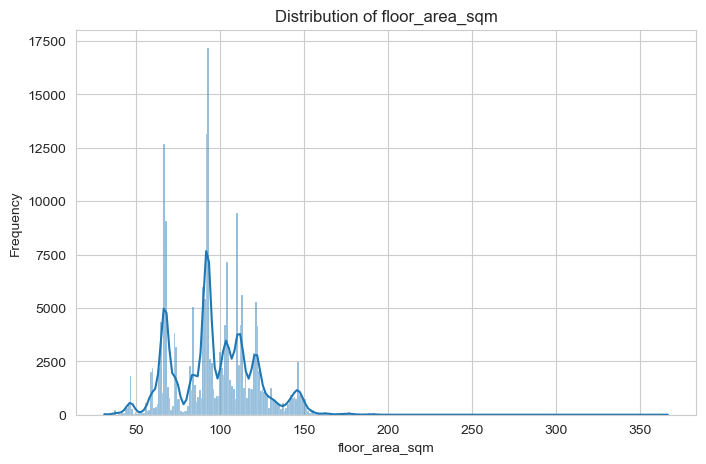

Skewness of floor_area_sqm: 0.26
The distribution is approximately symmetric.
Kurtosis of floor_area_sqm: 0.01
The distribution is platykurtic.


In [111]:
plot_numerical_column(df, 'floor_area_sqm')

**While the skewness of `floor_area_sqm` is low at 0.26, statistically suggesting an approximately symmetric distribution, visual inspection of the data reveals a long extension to the very right, with a maximum value of 366.7 sqm significantly higher than the 75th percentile of 112 sqm.**

**The relatively low skewness, despite this visible right tail, is likely due to the bulk of the distribution being quite symmetric around its central tendency, thus tempering the overall skewness metric. Furthermore, the likely multimodal nature of floor_area_sqm (reflecting distinct HDB flat types/sizes, such as 3-room, 4-room, 5-room, and executive flats) also contributes to lowering the aggregate skewness.**

**For linear regression models, we will not apply a direct transformation to floor_area_sqm based on its low overall skewness. However, we will carefully examine residual plots to ensure assumptions of linearity and homoscedasticity hold, as the long right tail and distinct modes could still subtly influence model behavior.**

**Conversely, tree-based models (such as Random Forest or Gradient Boosting) are inherently well-suited to handle multimodal feature distributions without requiring explicit transformations. Their ability to make splits based on thresholds allows them to naturally segment and learn from distinct peaks in the data.**

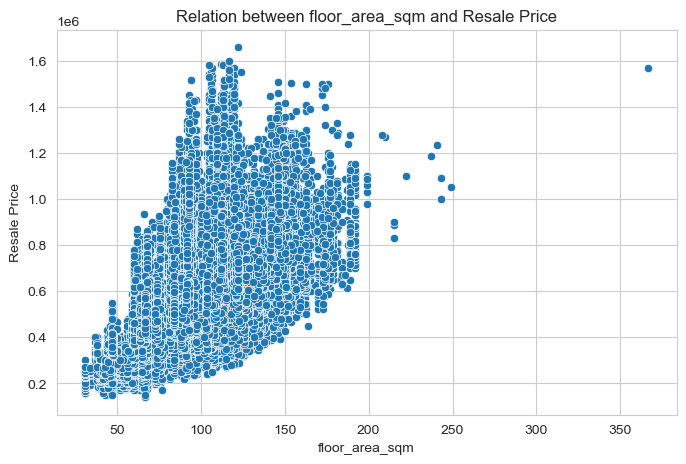

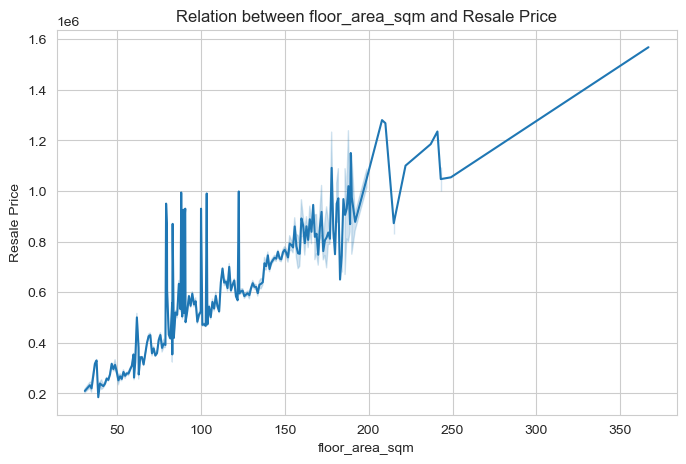

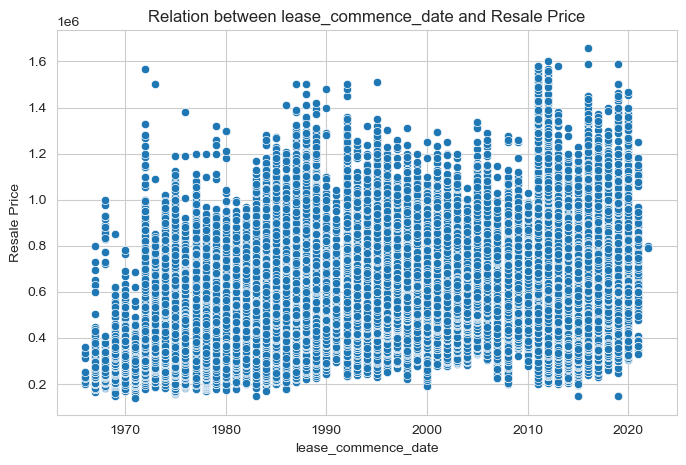

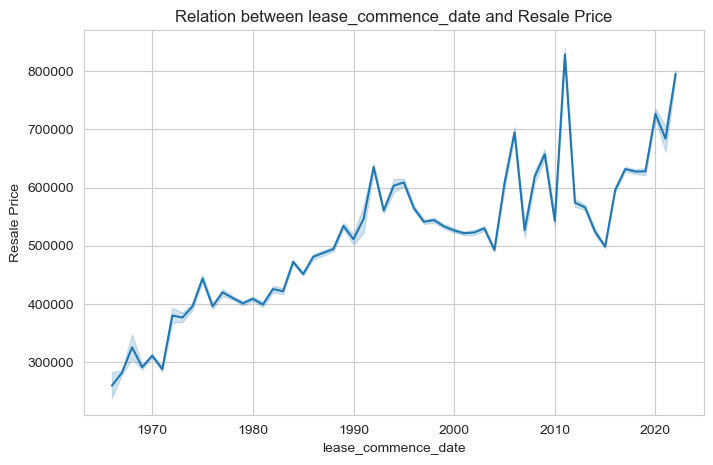

In [112]:
# Inspect the relation between features and target
for each_column in numerical_columns:
    plt.figure(figsize=(8,5))
    sns.scatterplot(data=df, x=each_column, y='resale_price')
    plt.title(f'Relation between {each_column} and Resale Price')
    plt.xlabel(each_column)
    plt.ylabel('Resale Price')
    plt.show()

    # plot the line plot of relation between features and resale price
    plt.figure(figsize=(8,5))
    sns.lineplot(data=df, x=each_column, y='resale_price')
    plt.title(f'Relation between {each_column} and Resale Price')
    plt.xlabel(each_column)
    plt.ylabel('Resale Price')
    plt.show()



In [113]:
df.corr(numeric_only=True)['resale_price'].sort_values()

lease_commence_date    0.369525
floor_area_sqm         0.580096
resale_price           1.000000
Name: resale_price, dtype: float64

**There is high collinearity between `floor_area_sqm` and the `resale_price`. There is moderate collinearity between `lease_commence_date` and `resale_price`.**

In [114]:
# Pearson & Spearman in one go
num_cols = df.select_dtypes('number').columns
corrs = df[num_cols].corr(method='spearman')['resale_price'].sort_values(ascending=False)
print(corrs.head(10))

resale_price           1.000000
floor_area_sqm         0.617240
lease_commence_date    0.412726
Name: resale_price, dtype: float64


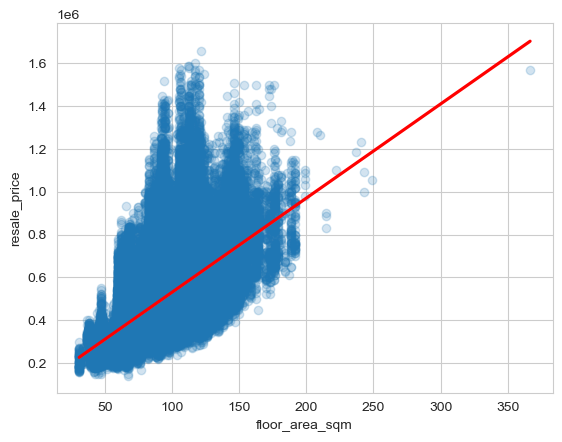

In [115]:
sns.regplot(x='floor_area_sqm', y='resale_price', data=df,
            scatter_kws={'alpha':0.2}, line_kws={'color':'red'})
plt.show()

/var/folders/s3/29d7926n31b40hc3rtxz_m_w0000gq/T/ipykernel_3498/1291059424.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = df.groupby('area_bin')['resale_price'].agg(['median','count'])


<Axes: xlabel='area_bin'>

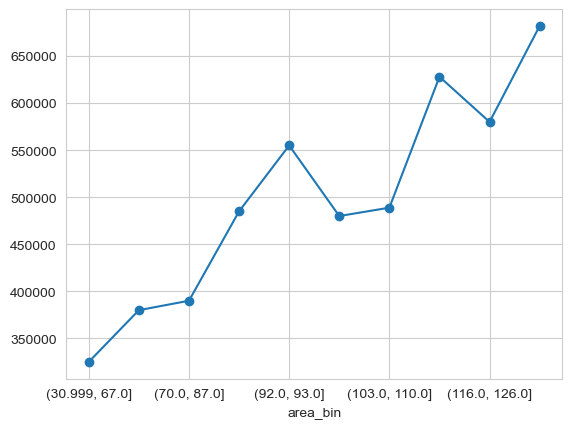

In [116]:
# Bin X into deciles and plot median target
df['area_bin'] = pd.qcut(df['floor_area_sqm'], 10, duplicates='drop')
bin_stats = df.groupby('area_bin')['resale_price'].agg(['median','count'])
bin_stats['median'].plot(marker='o')

### Categorical Columns

In [117]:
categorical_columns

Index(['month', 'town', 'flat_type', 'storey_range', 'flat_model',
       'remaining_lease'],
      dtype='object')

In [118]:
def plot_categorical_column(df: pd.DataFrame, column_name: str, rare_threshold: float = 0.01): # 0.01 (1%) is the default threshold for rare values
    """
    Display the statistics of the column
    Countplot of the column sorted by the value counts with highest value counts on top (horizontal view)
    Value counts sorted by the value counts with weights in percentage
    """
    # Display the column name
    print('========================================')
    print(column_name)
    print('--------------------------------')

    # Display the statistics of the column
    print(f'{column_name} describe:')
    print(df[column_name].describe())

    print('--------------------------------')
    # countplot of the column sorted by the value counts with highest value counts on top
    fig, ax = plt.subplots(figsize=(8,5))  

    sns.set_style("whitegrid")
    sns.countplot(data=df, y=column_name, order=df[column_name].value_counts().index)

    ax.set_title(f'Count of {column_name}')
    ax.set_xlabel('Count')
    ax.set_ylabel(column_name)
    ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation = 90)

    plt.tight_layout()
    plt.show()

    # Display the value counts with percentage
    value_counts = df[column_name].value_counts(dropna=False)
    value_counts_percentage = value_counts/len(df[column_name])
    value_count_rare_df = pd.DataFrame({
        "value_count"   : value_counts,
        "percent" : value_counts_percentage
    })
    value_count_rare_df["is_rare"] = value_count_rare_df["percent"] < rare_threshold

    print('--------------------------------')
    print(f'Rare threshold of {rare_threshold * 100}%')
    print(value_count_rare_df)
    print('========================================')

#### Categorical Feature Column: Month

month
--------------------------------
month describe:
count      209275
unique        102
top       2024-07
freq         3036
Name: month, dtype: object
--------------------------------


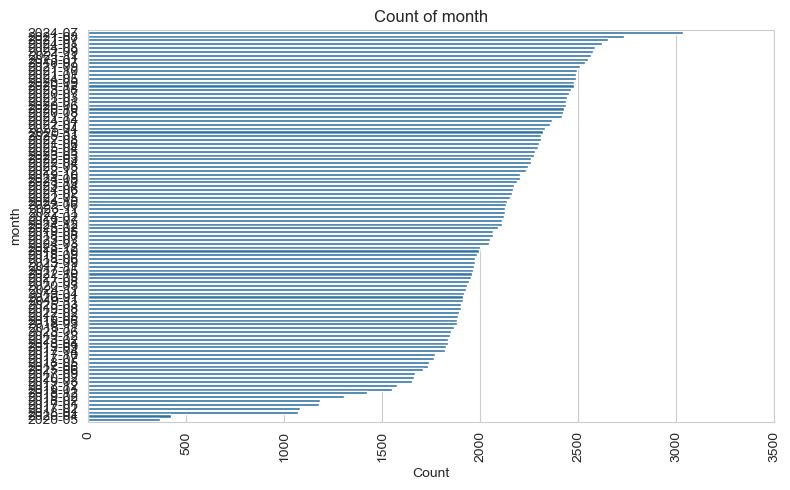

--------------------------------
Rare threshold of 1.0%
         value_count   percent  is_rare
month                                  
2024-07         3036  0.014507    False
2021-08         2735  0.013069    False
2021-07         2655  0.012687    False
2024-01         2620  0.012519    False
2024-08         2588  0.012367    False
...              ...       ...      ...
2017-01         1176  0.005619     True
2017-02         1080  0.005161     True
2018-01         1072  0.005122     True
2020-04          423  0.002021     True
2020-05          363  0.001735     True

[102 rows x 3 columns]


In [119]:
plot_categorical_column(df,'month')

**The feature `month`, need to convert to datetime format. However, ML models could not interpret datetime, therefore we need to convert them to numerical features in `transaction_year` and `transaction_month`. We will use `transaction_year` as ordinal numerical features. For `transaction_month`, this is seasonal, therefore we can either use one-hot encoding or cyclic sine/cosine pair (two columns that preserve the circular nature).**

**To simplified feature engineering, we will use one-hot encoding for `transaction_month`.**

In [120]:
def convert_month_to_year_month(df: pd.DataFrame, 
                              month: str = 'month',
                              transaction_year: str = 'transaction_year',
                              transaction_month: str = 'transaction_month') -> pd.DataFrame:
    """
    Convert month column to separate year and month columns.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Input dataframe containing the month column
    month : str, default 'month'
        Name of the column containing month data
    transaction_year : str, default 'transaction_year'
        Name of the output year column
    month_out_col : str, default 'transaction_month'
        Name of the output month column
    
    Returns:
    --------
    pd.DataFrame
        Modified dataframe
    
    Raises:
    -------
    ValueError
        If month_col doesn't exist in the dataframe
    TypeError
        If df is not a pandas DataFrame
    """
    
    # Input validation
    if not isinstance(df, pd.DataFrame):
        raise TypeError("Input must be a pandas DataFrame")
    
    # Check if dataframe is empty
    if df.empty:
        warnings.warn("Input dataframe is empty", UserWarning)
        return df.copy()
    
    # Check if month column exists
    if month not in df.columns:
        raise ValueError(f"Column '{month}' not found in dataframe")
    
    # Work on copy
    df = df.copy()
    
    # Convert to datetime with error handling
    try:
        df[month] = pd.to_datetime(df[month])
    except (ValueError, TypeError) as e:
        raise ValueError(f"Cannot convert column '{month}' to datetime: {str(e)}")
    
    # Extract year and month
    df[transaction_year] = df[month].dt.year
    df[transaction_month] = df[month].dt.month
    
    # Return dataframe
    return df

In [121]:
# =============================================================================
# SIMPLE TESTS - Run these in your notebook
# =============================================================================

def test_basic_functionality():
    """Test that the function works with normal data"""
    # Create test data
    test_df = pd.DataFrame({
        'month': ['2023-01-15', '2023-02-20', '2023-03-10'],
        'value': [100, 200, 300]
    })
    
    # Run function
    result = convert_month_to_year_month(test_df)
    
    # Check results
    assert 'transaction_year' in result.columns
    assert 'transaction_month' in result.columns
    assert result['transaction_year'].tolist() == [2023, 2023, 2023]
    assert result['transaction_month'].tolist() == [1, 2, 3]
    
    print("✓ Basic functionality test passed!")


test_basic_functionality()

✓ Basic functionality test passed!


In [122]:

def test_different_date_formats():
    """Test with different date formats"""
    test_df = pd.DataFrame({
        'month': ['2023-01', '2023-02', '2023-03'],
        'value': [100, 200, 300]
    })
    
    result = convert_month_to_year_month(test_df)
    
    assert result['transaction_year'].iloc[0] == 2023
    assert result['transaction_month'].iloc[0] == 1
    
    print("✓ Different date formats test passed!")

test_different_date_formats()

✓ Different date formats test passed!


In [123]:

def test_with_nulls():
    """Test with null values"""
    test_df = pd.DataFrame({
        'month': ['2023-01-15', None, '2023-03-10'],
        'value': [100, 200, 300]
    })
    
    result = convert_month_to_year_month(test_df)
    
    # First and third rows should work
    assert result['transaction_year'].iloc[0] == 2023
    assert result['transaction_month'].iloc[0] == 1
    
    print("✓ Null values test passed!")

test_with_nulls()

✓ Null values test passed!


In [124]:

def test_original_unchanged():
    """Test that original dataframe is not modified"""
    original_df = pd.DataFrame({
        'month': ['2023-01-15', '2023-02-20'],
        'value': [100, 200]
    })
    
    # Store original state
    original_columns = original_df.columns.tolist()
    
    # Run function
    result = convert_month_to_year_month(original_df)
    
    # Check original is unchanged
    assert original_df.columns.tolist() == original_columns
    assert 'transaction_year' not in original_df.columns
    
    # Check result has new columns
    assert 'transaction_year' in result.columns
    
    print("✓ Original unchanged test passed!")

test_original_unchanged()

✓ Original unchanged test passed!


#### Categorical Feature Column: Town

town
--------------------------------
town describe:
count       209275
unique          26
top       SENGKANG
freq         17179
Name: town, dtype: object
--------------------------------


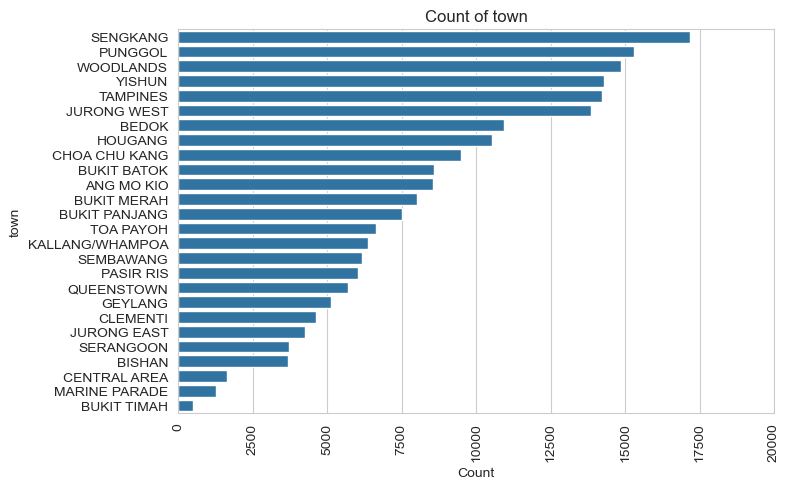

--------------------------------
Rare threshold of 1.0%
                 value_count   percent  is_rare
town                                           
SENGKANG               17179  0.082088    False
PUNGGOL                15295  0.073086    False
WOODLANDS              14868  0.071045    False
YISHUN                 14284  0.068255    False
TAMPINES               14233  0.068011    False
JURONG WEST            13868  0.066267    False
BEDOK                  10935  0.052252    False
HOUGANG                10528  0.050307    False
CHOA CHU KANG           9502  0.045404    False
BUKIT BATOK             8590  0.041046    False
ANG MO KIO              8572  0.040960    False
BUKIT MERAH             8016  0.038304    False
BUKIT PANJANG           7516  0.035914    False
TOA PAYOH               6642  0.031738    False
KALLANG/WHAMPOA         6391  0.030539    False
SEMBAWANG               6176  0.029511    False
PASIR RIS               6041  0.028866    False
QUEENSTOWN              5718  0.

In [125]:
plot_categorical_column(df,'town')

**The feature `town` has 26 unique values. Since town is a nominal categorical variable and not ordinal, we will use one-hot encoding. The top 3 towns with the highest transaction turnover are SENGKANG, PUNGGOL, and WOODLANDS.**

**The towns CENTRAL AREA, MARINE PARADE, and BUKIT TIMAH have transaction counts that are less than 1% of the total transactions. Due to their rare occurrence, these categories might potentially impact predictive power, particularly for models sensitive to sparsity. One option to address this could be to group these three towns into a single "RARE" or "PREMIUM" category to potentially improve predictive capabilities.**

**However, grouping them may distort valuable information if there are changes to the trends or characteristics of these specific towns in future data. Therefore, we have decided to keep all towns as separate categories with one-hot encoding. We will be using tree-based models, which are robust to rare categories and high-cardinality features, to handle these less frequent occurrences effectively.**

#### Categorical Feature Column: Flat type

flat_type
--------------------------------
flat_type describe:
count     209275
unique         7
top       4 ROOM
freq       88457
Name: flat_type, dtype: object
--------------------------------


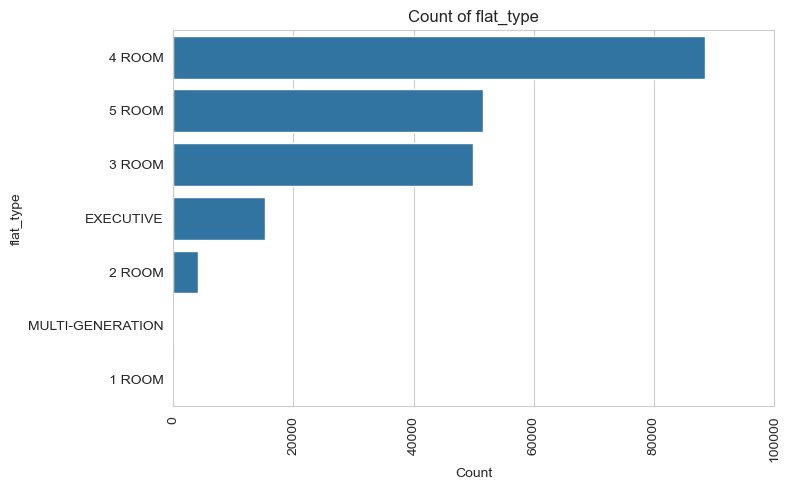

--------------------------------
Rare threshold of 1.0%
                  value_count   percent  is_rare
flat_type                                       
4 ROOM                  88457  0.422683    False
5 ROOM                  51545  0.246303    False
3 ROOM                  49809  0.238007    False
EXECUTIVE               15207  0.072665    False
2 ROOM                   4097  0.019577    False
MULTI-GENERATION           83  0.000397     True
1 ROOM                     77  0.000368     True


In [126]:
plot_categorical_column(df, 'flat_type')

**Analysis of `flat_type` Feature:**

**The `flat_type` feature contains 7 unique categories. The most popular resale flat types are 4 ROOM (42.27%), followed by 5 ROOM (24.63%) and 3 ROOM (23.80%), collectively accounting for the vast majority of transactions.**

**Given the inherent ordinality of flat types (e.g., 1-room, 2-room, 3-room, 4-room, 5-room, Executive, Multi-Generation typically representing increasing size), we may consider ordinal encoding for models that can leverage this ordered relationship, such as linear models.** 

**However, we discovered that there are exceptions and outliers in 3-room flat with floor area more than 200sqm. This is unusual. We found that during the 1960s, there are terrace flat model which are categorized as 3-room flat, these flats has very high floor area that are more than 200sqm. HDB has stop building such flat. Given the new information, we think that it is best to use one-hot encoding as it avoids assumptions about the linearity of the ordinal relationship.** 

**The MULTI-GENERATION and 1 ROOM flat types each represent less than 0.04% of total transactions, falling below our 1.0% rare threshold. We have decided not to group these sparse categories into an 'Other' type. This is because despite their rare occurrence, these specific flat types likely contain valuable and distinct information (e.g., 1-room flats typically being the smallest/lowest priced, and multi-generation flats being unique, large units). To effectively handle these rare occurrences and capture their potentially unique impact without distortion, we will rely on robust model-level smoothing provided by ensemble models (e.g., Random Forest, Gradient Boosting), which are well-suited for sparse categorical features.**

#### Categorical Feature Column: Storey Range

storey_range
--------------------------------
storey_range describe:
count       209275
unique          17
top       04 TO 06
freq         48025
Name: storey_range, dtype: object
--------------------------------


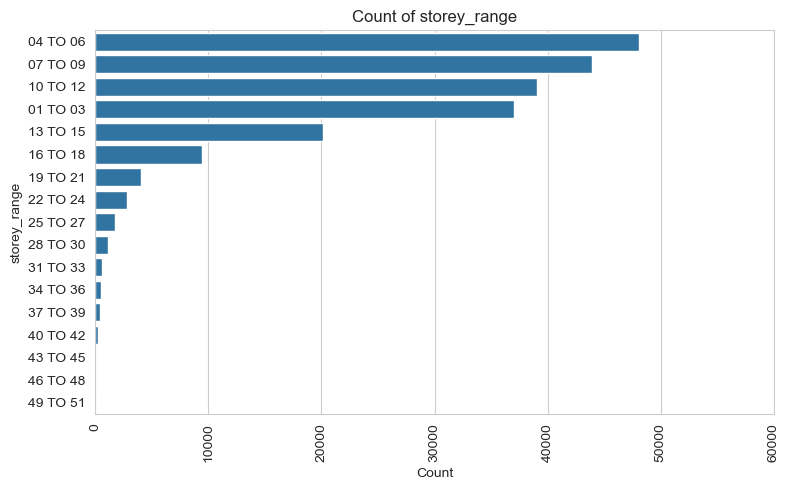

--------------------------------
Rare threshold of 1.0%
              value_count   percent  is_rare
storey_range                                
04 TO 06            48025  0.229483    False
07 TO 09            43889  0.209719    False
10 TO 12            39041  0.186554    False
01 TO 03            37005  0.176825    False
13 TO 15            20132  0.096199    False
16 TO 18             9410  0.044965    False
19 TO 21             4047  0.019338    False
22 TO 24             2848  0.013609    False
25 TO 27             1761  0.008415     True
28 TO 30             1138  0.005438     True
31 TO 33              618  0.002953     True
34 TO 36              552  0.002638     True
37 TO 39              462  0.002208     True
40 TO 42              220  0.001051     True
43 TO 45               64  0.000306     True
46 TO 48               45  0.000215     True
49 TO 51               18  0.000086     True


In [127]:
plot_categorical_column(df, 'storey_range')

**Given its ordinarity nature, we will the categories from string to numerical number. We do that by extracting the numerical number and take the average. For example, if storey range is from 7th floor to 9th floor. We will take the middle floor, 8th floor as the indicator.**

In [128]:
def convert_storey_range(storey_range):
    """
    Convert storey range to the numerical average.
    Args:
        storey_range in (str)

    Returns: 
        float

    Example:
        convert_storey_range('07 TO 09') -> 8.0 
    """

    low, high = storey_range.split(' TO ')
    average = (int(low) + int(high)) / 2
    return average

In [129]:
df.storey_range = df.storey_range.apply(convert_storey_range)
df.storey_range

0         11.0
1          2.0
2          2.0
3          5.0
4          2.0
          ... 
209574    11.0
209575     8.0
209576     5.0
209577     5.0
209578     5.0
Name: storey_range, Length: 209275, dtype: float64

In [68]:
df.storey_range

0         11.0
1          2.0
2          2.0
3          5.0
4          2.0
          ... 
209574    11.0
209575     8.0
209576     5.0
209577     5.0
209578     5.0
Name: storey_range, Length: 209275, dtype: float64

In [66]:
df.storey_range.describe()

count    209275.000000
mean          8.760010
std           5.936299
min           2.000000
25%           5.000000
50%           8.000000
75%          11.000000
max          50.000000
Name: storey_range, dtype: float64

**This feature column has been convert as numerical columns as it contains ordinality and we can take the average as the reference indicator.**

#### Categorical Feature Column: Flat Model

flat_model
--------------------------------
flat_model describe:
count      209275
unique         21
top       Model A
freq        74239
Name: flat_model, dtype: object
--------------------------------


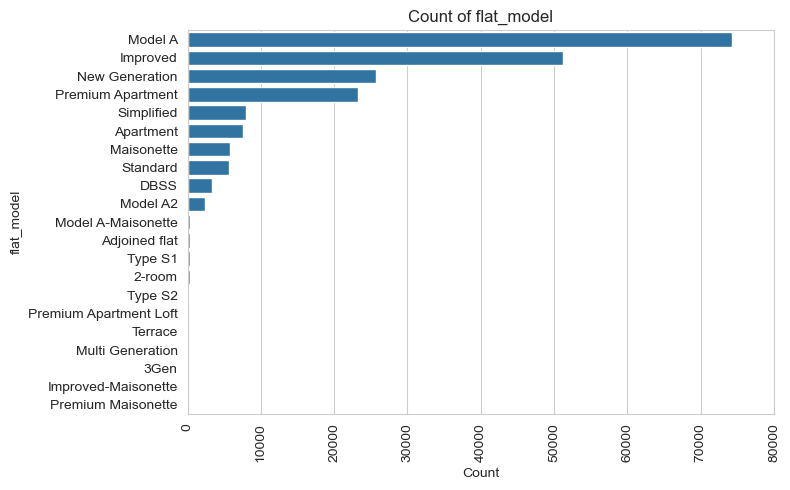

--------------------------------
Rare threshold of 1.0%
                        value_count   percent  is_rare
flat_model                                            
Model A                       74239  0.354744    False
Improved                      51268  0.244979    False
New Generation                25738  0.122987    False
Premium Apartment             23219  0.110950    False
Simplified                     8026  0.038351    False
Apartment                      7633  0.036474    False
Maisonette                     5816  0.027791    False
Standard                       5632  0.026912    False
DBSS                           3387  0.016184    False
Model A2                       2374  0.011344    False
Model A-Maisonette              371  0.001773     True
Adjoined flat                   358  0.001711     True
Type S1                         341  0.001629     True
2-room                          283  0.001352     True
Type S2                         178  0.000851     True
Premium A

In [131]:
plot_categorical_column(df, 'flat_model')

**There are more sparse categories, however, each categories contains its unique information which maybe helpful in differentiating between different type of flats with different model and its different pricing. We will use one-hot encoding since there is no ordinarity in this feature.**

**Examples:**

- Maisonette and Premium Maisonette are duplex units.
- DBSS (Design, Build and Sell Scheme) flats were built by private developers and often have condo-like features.
- Terrace flats are the specific, large 3-room flats build in the 1960s.
- Multi Generation and 3Gen are specific multi-generational living units.

**These are not just "rare" in frequency but "rare" in their type and market position. Grouping them into an "Other" category would likely lead to a significant loss of valuable information.**

**We will be using tree-based ensemble model to handle the sparsity of the features.**

#### Categorical Feature Column: Remaining Lease

remaining_lease
--------------------------------
remaining_lease describe:
count                 209275
unique                   690
top       94 years 10 months
freq                    1860
Name: remaining_lease, dtype: object
--------------------------------


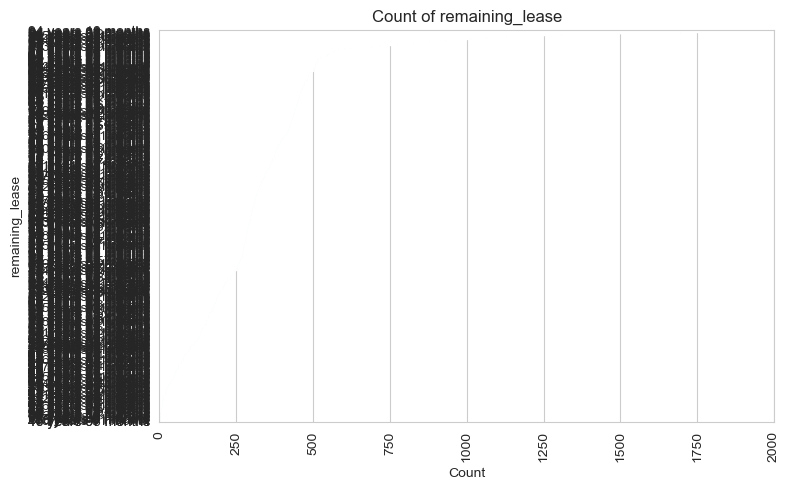

--------------------------------
Rare threshold of 1.0%
                    value_count   percent  is_rare
remaining_lease                                   
94 years 10 months         1860  0.008888     True
94 years 09 months         1835  0.008768     True
94 years 11 months         1803  0.008615     True
94 years 08 months         1694  0.008095     True
94 years 07 months         1577  0.007536     True
...                         ...       ...      ...
66 years 0 months             1  0.000005     True
95 years 0 months             1  0.000005     True
40 years 01 month             1  0.000005     True
40 years 05 months            1  0.000005     True
40 years 07 months            1  0.000005     True

[690 rows x 3 columns]


In [132]:
plot_categorical_column(df, 'remaining_lease')

**With 690 categories, we consider this feature has high cardinality. Thus we will convert this feature from string to numerical column. We will convert the remaining lease into a new column `remaining_lease_by_month`. We will convert the years into months and add to the remaining months. For example, `94 years 10 months` will be converted to 1138 months.**

In [133]:
def convert_lease_to_month(lease):
    """
    Convert remaining lease period from string to total number of months.
    Args:
        remaining_lease in (str)

    Returns: 
        integer

    Example:
        convert_lease_to_month('07 TO 09') -> 8.0  
    """
    str_list = lease.split(' ')
    if ('months' in str_list) | ('month' in str_list):
        year = int(str_list[0])
        month = int(str_list[2])
        t_month = (year * 12) + month 
    elif ('years' in str_list) & (('months' not in str_list) | ('month' not in str_list)):
        year = int(str_list[0])
        t_month = (year * 12)
    else:
        year = int(str_list[0])
        t_month = (year * 12)        
    return t_month

In [134]:
df['remaining_lease_by_month'] = df.remaining_lease.apply(convert_lease_to_month)

In [135]:
df['remaining_lease_by_month'].describe()

count    209275.000000
mean        892.494631
std         169.868268
min         481.000000
25%         752.000000
50%         891.000000
75%        1064.000000
max        1173.000000
Name: remaining_lease_by_month, dtype: float64

**By converting this feature from string with year and months into numerical months, we can better manage this feature and this feature column also carry important information of the remaining live of a flat that may impacted the resale price.**

## Bivariate Analysis: Feature vs Target

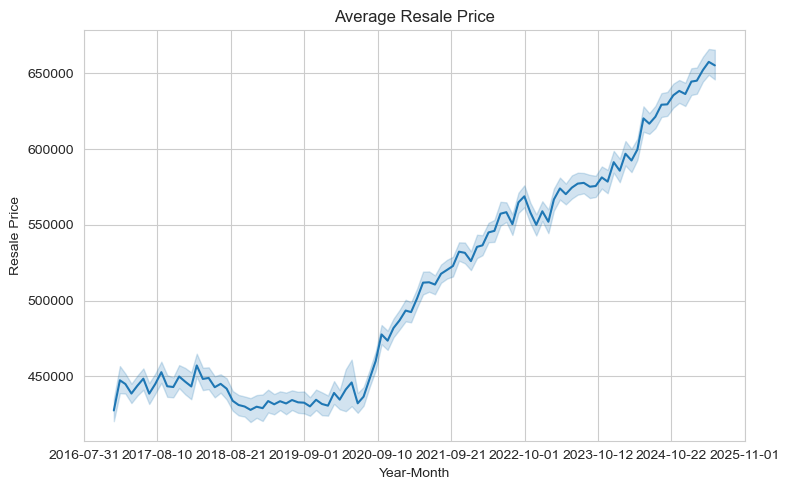

In [136]:
month_dt = pd.to_datetime(df['month'])
df_sorted = df.assign(month_dt=month_dt).sort_values('month_dt')

fig, ax = plt.subplots(figsize=(8,5))  

sns.lineplot(data=df_sorted, x='month_dt', y='resale_price', estimator='mean')

ax.set_title('Average Resale Price')
ax.set_xlabel('Year-Month')
ax.set_ylabel('Resale Price')
ax.xaxis.set_major_locator(ticker.LinearLocator(10))

plt.tight_layout()
plt.show()

**Average resale price varies over the years. This could be due to different flat types and location. It will be more meaningful to explore the average price by flat type. floor area and location.**

### Cyclical Analysis of Resale Transaction

In [ ]:
month_counts = df.month.value_counts().sort_index()
month_counts.head()

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))  

sns.lineplot(x=month_counts.index, y=month_counts.values, ax=ax)

ax.set_title('Trend of Number of Resale Listings Over the Months')
ax.set_xlabel('Year-Month')
ax.set_ylabel('Number of Resale Transaction')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.tight_layout()
plt.show()

**HDB resale is seasonal and the month of February has the lowers resale transaction.**

### Million Dollar HDB

In [ ]:
# Extract resale price that is more than 1 million excluding 2016
df_high_price = df[df['resale_price'] > 1000000].copy()

# add year column 
df_high_price['year'] = pd.to_datetime(df_high_price['month']).dt.year
df_high_price = df_high_price[df_high_price['year'] != 2019]

# print the number of flats with resale price above 1 million
print(f"Number of flats with resale price above 1 million: {len(df_high_price)}")

# calculate the percentage of high resale price flats against total flats
high_price_percentage = (len(df_high_price) / len(df)) * 100
print(f"Percentage of flats with resale price above 1 million: {high_price_percentage:.2f}%") 

In [ ]:
# plot the distribution of resale price to see total number of high price flats for every year
df_high_price['year'].value_counts().sort_index()
df_high_price['year'].value_counts().sort_index().plot(kind='bar', figsize=(8,5))
plt.title('Number of Flats with Resale Price Above 1 Million by Year excluding 2019')
plt.xlabel('Year')
plt.ylabel('Number of Flats')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Town 

**Top 3 town with the highest turn over is Jurong West, Woodlands and Sengkang.**

### Flat Model Name 

**There are also missing values in flat model name.**

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,10))  
sns.set_style("whitegrid")

sorted_flat_model_name = df.flatm_name.value_counts()
sorted_flat_model_index = sorted_flat_model_name.index
sns.countplot(data=df, x='flatm_name', order=sorted_flat_model_index, ax=ax1)

ax1.set_title('Flats Count by Flat Model')
ax1.set_xlabel('Flat Model')
ax1.set_ylabel('Number of Flats Sold')
ax1.set_xticks(ax1.get_xticks(), ax1.get_xticklabels(), rotation = 90)


sorted_flat_model_id = df.flatm_id.value_counts()
sorted_flat_model_id_index = sorted_flat_model_id.index
sns.countplot(data=df, x='flatm_id', order=sorted_flat_model_id_index, ax=ax2)

ax2.set_title('Flats Count by Flat Model ID')
ax2.set_xlabel('Flat Model ID')
ax2.set_ylabel('Number of Flats Sold')

plt.tight_layout()
plt.show()

In [ ]:
np.c_[sorted_flat_model_name.index, sorted_flat_model_id.index, sorted_flat_model_name, sorted_flat_model_id]

**Base on the table above, we can see that `Simplified`, `Apartment`, `Maisonette` and `Standard` flat model name can be filled by corresponding flat model id.**

In [ ]:
model_name = sorted_flat_model_name.index.to_list()
model_id = sorted_flat_model_id.index.to_list()
model_name_mapping = dict(zip(model_id, model_name))
model_name_mapping

In [ ]:
df.loc[df.flatm_name.isnull(),'flatm_id'].map(model_name_mapping)

In [ ]:
df.loc[df.flatm_name.isnull(), 'flatm_name'] = df.loc[df.flatm_name.isnull(),'flatm_id'].map(model_name_mapping)

In [ ]:
df.isnull().sum()

**Top 3 model with the most transaction is Model A, Improved and New Generation.**

### Flat Type and Resale Price

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))  

sns.boxplot(data=df, x='flat_type', y='resale_price', hue='flat_type', palette='Set1')

ax.set_title('Resale Price by Flat Type')
ax.set_xlabel('Flat Type')
ax.set_ylabel('Resale Price')
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

**There are many outliers for '2 ROOM', '3 ROOM', '4 ROOM', '5 ROOM', and 'EXECUTIVE' flats. Outliers likely happen maybe due to locations or renovation status.**

### Flat Type and Floor Area

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))  

sns.scatterplot(data=df, x='floor_area_sqm', y='resale_price', hue='flat_type', palette='Set1')

ax.set_title('Scatter Plot of Floor Area vs Resale Price by Flat Type')
ax.set_xlabel('Floor Area (sqm)')
ax.set_ylabel('Resale Price')

plt.tight_layout()
plt.show()

**Generally, the increase in floor area result in increase in resale price.**
  
**There are 3 ROOM flats that has a very high selling price and the floor area is also quite high. We need to investigate further.**

In [ ]:
outliers_3_room = df[(df['flat_type'] == '3 ROOM') & (df['floor_area_sqm'] > 150) & (df['resale_price'] > 800000)]
outliers_3_room

**The outliers are 3 ROOM flats that are built in 1972 where they have floor area of 180 sqm and above. Therefore, flat type is not good enough to differentiate the resale price. Flat model also plays an important differentiator.**

In [ ]:
terrace_3_room = df[(df['flat_type'] == '3 ROOM') & (df['flatm_name'] == "Terrace")]
terrace_3_room.describe()

- **Terrace was built between 1968 to 1972.**
- **Both floor area and resale price and very wide range.**
- **sqm range from 78 sqm to 280 sqm.**

Checking other similar situation.

In [ ]:
df[['flat_type', 'flatm_name', 'floor_area_sqm', 'resale_price']].groupby(['flat_type', 'flatm_name']).mean()

**Besides 3 ROOM flat, other flat type also contains Terrace model. To get a more accurate prediction, flat type and flat model must be used together.**

### Million Dollar HDB

In [ ]:

# plot the distribution of resale price to see total number of high price flats for every year
df_high_price['year'] = pd.to_datetime(df_high_price['month']).dt.year
df_high_price['year'].value_counts().sort_index()
df_high_price['year'].value_counts().sort_index().plot(kind='bar', figsize=(8,5))
plt.title('Number of Flats with Resale Price Above 1 Million by Year')
plt.xlabel('Year')
plt.ylabel('Number of Flats')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Average Resale Price By Town, Type and Model Analysis

In [ ]:
town_breakdown = df[['town_name', 'floor_area_sqm', 'resale_price']].groupby(['town_name'])
town_breakdown[['floor_area_sqm']].describe()

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))  

sns.boxplot(data=df, x='town_name', y='floor_area_sqm', hue='town_name', palette='Set1')

ax.set_title('Floor Area by Town')
ax.set_xlabel('Town')
ax.set_ylabel('Floor Area (sqm)')
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels([label.get_text() for label in ax.get_xticklabels()], rotation=90)

plt.tight_layout()
plt.show()

**The chart shows that some town contains more outliers than other town in terms of floor area. KALLANG/WHAMPOA has many outliers that goes beyond 250 sqm. These are the 3 Room terrace that we discovered earlier.**

In [ ]:
town_breakdown[['resale_price']].describe()

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))  

sns.boxplot(data=df, x='town_name', y='resale_price', hue='town_name', palette='Set1')

ax.set_title('Resale Price by Town')
ax.set_xlabel('Town')
ax.set_ylabel('Resale Price')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.tight_layout()
plt.show()

**Some town command higher median selling price compared to other town.**

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))  

f1 = sns.histplot(data=df, x='town_name', hue='flat_type', palette='Set1', alpha=1)
sns.move_legend(f1, "upper left", bbox_to_anchor=(1, 0.6))

ax.set_title('Number of Transaction by Town and Flat Type')
ax.set_xlabel('Town')
ax.set_ylabel('Number of Transaction')
ax.set_xticks(ax.get_xticks(), [label.get_text() for label in ax.get_xticklabels()], rotation=90)

plt.tight_layout()
plt.show()


**Some flat type such as 3 ROOM is only available for sales in older towns.**

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))  

f1 = sns.histplot(data=df, x='town_name', hue='flatm_name', palette='Set2', alpha=1)
sns.move_legend(f1, "upper left", bbox_to_anchor=(1, 0.6))

ax.set_title('Number of Transaction by Town and Flat Model')
ax.set_xlabel('Town')
ax.set_ylabel('Number of Transaction')
ax.set_xticks(ax.get_xticks(), [label.get_text() for label in ax.get_xticklabels()], rotation=90)

plt.tight_layout()
plt.show()

**Some model is only available at some town.**

In [ ]:
town_type_breakdown = df[['town_name', 'flat_type', 'floor_area_sqm', 'resale_price']].groupby(['town_name', 'flat_type'])
print(town_type_breakdown[['floor_area_sqm']].describe().to_string())



In [ ]:
print(town_type_breakdown[['resale_price']].describe().to_string())

**If we breakdown the flat by town and flat type, the dispersion of the floor area and resale price is still wide. But the dispersion of floor area and resale price is narrower compared to just using one classification category. This is due to different flat model.**

In [ ]:
full_breakdown = df[['town_name', 'flat_type', 'flatm_name', 'floor_area_sqm', 'resale_price']].groupby(['town_name', 'flat_type', 'flatm_name'])


In [ ]:
print(full_breakdown[['floor_area_sqm']].describe().to_string())

In [ ]:
print(full_breakdown[['resale_price']].describe().to_string())

**If we breakdown the flat by town, flat type and flat model, for some location, there is no dispersion. However for some location, the dispersion of the floor area and resale price is much narrower compared to previous grouping and classification. However, some flat model still present a slightly wide dispersion in terms of flat model and resale price.**

In [ ]:
group_flat_model_sqm = df[['flat_type', 'flatm_name', 'floor_area_sqm', 'resale_price']].groupby(['flat_type', 'flatm_name', 'floor_area_sqm']).mean()
print(group_flat_model_sqm.to_string())

**Even if we fine tuned the flat selection by model type, there are many variation in terms of floor area. For example, in a 5 Room Model A flat we have a range of 129 sqm to 157 sqm. This proves that if we narrow our selection to model type, we may not have accurate prediction without the indication of floor area.**

**Our initial conclusion is that the best feature to predict housing price is the floor area. However, we will keep the flat type and flat model to provide us segmentation information so that we can improve the prediction of resale price.**

### Selected Break Down of Resale Price

#### 4 ROOM with Model A by Town

In [ ]:
four_model_A = df.loc[(df['flat_type']=='4 ROOM') & (df['flatm_name']=='Model A'),['town_name', 'floor_area_sqm', 'resale_price']]

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))  

sns.boxplot(data=four_model_A, x='town_name', y='resale_price', hue='town_name', palette='Set1')

ax.set_title('Resale Price by Town for 4 Room Flat Model A')
ax.set_xlabel('Town')
ax.set_ylabel('Resale Price')
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels([label.get_text() for label in ax.get_xticklabels()], rotation=90)

plt.tight_layout()
plt.show()

**The more we breakdown by town, flat type and flat model, the less dispersion is the resale price. However, it is clear that not every town command the same resale price for the same type of flat with the same model.**

### Remaining Lease

In [ ]:
df.remaining_lease.unique()

**Remaining lease is either in year or in year and month. We assume numbers without indicating month or year belongs to year.** 

In [ ]:
df.remaining_lease.isnull().sum()

**We need to convert the remaining lease to months as a standard indicator.**

In [ ]:
def convert_lease_to_month(lease):
    """
    Convert remaining lease period from string to total number of months.
    Args:
        remaining_lease in (str)

    Returns: 
        integer

    Example:
        convert_lease_to_month('07 TO 09') -> 8.0  
    """
    str_list = lease.split(' ')
    if ('months' in str_list) | ('month' in str_list):
        year = int(str_list[0])
        month = int(str_list[2])
        t_month = (year * 12) + month 
    elif ('years' in str_list) & (('months' not in str_list) | ('month' not in str_list)):
        year = int(str_list[0])
        t_month = (year * 12)
    else:
        year = int(str_list[0])
        t_month = (year * 12)        
    return t_month

In [ ]:
df['remaining_lease_by_month'] = df.remaining_lease.apply(convert_lease_to_month)

### Correlation Analysis

In [ ]:
df.info()

In [ ]:
corr_column = df[['floor_area_sqm', 'lease_commence_date', 'remaining_lease_by_month', 'resale_price']]
corr_matrix_pear = corr_column.corr(method='pearson')
corr_matrix_pear

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))  

sns.heatmap(corr_matrix_pear, annot=True, cmap='coolwarm', vmin=0, center=0.5, vmax=1, linewidths=0.5, fmt=".2f")

ax.set_title('Pearson Correlation Heatmap')

plt.tight_layout()
plt.show()

**There is a strong correlation between floor area and resale price. There is also moderate correlation between resale price and lease commence date which in turn indicating the age of the flat. The features, lease commence date and remaining lease in months are highly correlated. Therefore, it is suggested that we either use Ridge Regression to reduce the impact of multicollinearity or we drop one of the feature.** 

In [ ]:
df.storey_range = df.storey_range.apply(convert_storey_range)

In [ ]:
df.storey_range

In [ ]:
spearman_col = df[['storey_range', 'floor_area_sqm', 'lease_commence_date', 'remaining_lease_by_month', 'resale_price']]
spearman_corr = spearman_col.corr(method='spearman')

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))  

sns.heatmap(spearman_corr, annot=True, cmap='coolwarm', vmin=0, center=0, vmax=1, linewidths=0.5, fmt=".2f")

ax.set_title('Spearman Correlation Matrix Heatmap')

plt.tight_layout()
plt.show()

**There is strong correlation between floor area and resale price. Moderate correlation between age of the flat and the resale price. Moderate to weak correlation between height of the flat and resale price. Similarly, there is high correlation between lease commence date and remaining lease in months. Remaining lease in months are slightly more correlated to the resale price, as it is more granular. Therefore, we can consider dropping lease commence date if necessary.**

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))  

sns.lineplot(df, x = df.floor_area_sqm, y=df.resale_price)

ax.set_title('Price vs Floor Area (sqm)')

plt.tight_layout()
plt.show()

**There is a linear trend in terms of resale price and its biggest contributor.**

## EDA Findings

**Resale Price**
- **The mean of resale price is around $438K and the median is around 408K. Resale prices range from $160K to $1.2M. Based on the chart, the distribution of the resale price skewed to the right. This means that there are expensive flat that extends to the right. Lower priced flats are more concentrated. The skewness will cause the model to over-estimate the normal range houses. Either we use transformation on the target or we use other model that are robust to the skewness.**

**Feature Analysis**
- **Top 3 town with the highest turn over is Jurong West, Woodlands and Sengkang. The most popular resale flat type is 4 ROOM, follow by 3 ROOM and 5 ROOM flat. Top 3 model with the most transaction is Model A, Improved and New Generation.**
- **For 3 ROOM flats, there are outliers. These outliers belongs to old 3 ROOM flat that comes with a Terrace model. These flats are built between 1968 and 1972. The floor area ranges from 78 sqm to 880 sqm. Therefore, flat type is not good enough to differentiate the resale price. Flat model also plays an important differentiator.**
- **Besides 3 ROOM flat, other flat type also contains Terrace model. To get a more accurate prediction, flat type and flat model must be used together.**
- **Some flat type such as 3 ROOM is only available at older towns. Some model such as 'New Generation' is only available at some town.**
- **For the same flat type with the same model and similar floor area, not every town command the similar resale price range. Some town has higher median resale price compared to other town. This proves that location matters.**
- **If we breakdown the flat by town, flat type and flat model, for some location, there is no dispersion. However for some location, the dispersion of the floor area and resale price is much narrower compared to fewer grouping. However, some flat model still present a slightly wide dispersion in terms of flat model and resale price.**
- **Even if we fine tuned the flat selection by model type, there are many variation in terms of floor area. For example, in a 5 Room Model A flat we have a range of floor area between 129 sqm to 157 sqm. This proves that if we narrow our selection to flat type and model type, we may not have accurate prediction without the indication of floor area.**

**Feature Analysis Conclusion** 
- **Our initial conclusion is that the best feature to predict housing price is the floor area. However, we will can keep the flat type and flat model to provide us segmentation information so that we can improve the prediction of resale price. Location information is important to differentiate the price in different town.**

**Correlation Analysis**
- **For Pearson correlation analysis, there is a strong correlation between floor area and resale price. There is also moderate correlation between resale price and lease commence date which in turn indicating the age of the flat. The features, lease commence date and remaining lease in months are highly correlated. Therefore, it is suggested that we either use Ridge Regression to reduce the impact of multicollinearity or we drop one of the feature.** 
- **For Spearman Correlation Analysis, there is strong correlation between floor area and resale price. Moderate correlation between age of the flat and the resale price. Moderate to weak correlation between height of the flat and resale price. Similarly, there is high correlation between lease commence date and remaining lease in months. Remaining lease in months are slightly more correlated to the resale price, as it is more granular. Therefore, we can consider dropping lease commence date if necessary.**
- **Additional chart show a linear relation between hdb resale price and the floor area.**

### Conclusion

- **Floor area is the most important feature follow by age of the flat and the height of the flat.**
- **For the age of the flat, we will drop the column `lease_commence_date` and keep `remaining_lease_by_month`.** 
- **Other factor that are not in correlation analysis such as location information (`town_name`) also provide important signal on pricing prediction.**
- **We will keep the `flat_type` and `flatm_name` (flat model) to improve the prediction by providing segmental information.**
- **Investigation in our EDA suggested that there are many variation in `flat_type`. For example, a 3-room flat, the floor area ranges from 78sqm to 280 sqm. Therefore, we think that `flat_type` should be nominal instead of ordinal.**
- **Lastly, we will keep transaction year and month, to help with the seasonal resale price prediction.**

## Data Cleaning

In [ ]:
# Load the dataset
df = pd.read_csv('./data/resale_transactions.csv')

In [ ]:
len(df)

### Removing Duplicates

In [ ]:
# Remove duplicated items
df.drop_duplicates(inplace=True)

In [ ]:
df.duplicated().sum()

In [ ]:
len(df)

### Handling Negatives Value

In [ ]:
# Remove negative number in lease commence date
df.lease_commence_date = df.lease_commence_date.abs()

In [ ]:
df.describe()

### Standardizing Categorical Labels

In [ ]:
df.flat_type = df.flat_type.replace('FOUR ROOM', '4 ROOM')

In [ ]:
df.flat_type.unique()

### Handling Missing Values

In [ ]:
def handling_missing_name(df: pd.DataFrame, missing_name_col: str, missing_name_related_id_col:str) -> pd.DataFrame:
    """ 
    Fills missing values in the 'name' column from the 'id' column.

        Args:
        -----
        df (pd.DataFrame): The DataFrame containing the columns to be fixed.
        missing_name_related_id_col (str): The name of the column containing the IDs that matches the name.
        missing_name_col (str): The name of the column containing missing names to be filled.

        Returns:
        --------
        pd.DataFrame: The DataFrame with missing values fixed.
    """

    missing_name_rows = df[missing_name_col].isnull()
    list_name = df[missing_name_col].value_counts().index.to_list()
    list_id = df[missing_name_related_id_col].value_counts().index.to_list()

    missing_name_mapping = dict(zip(list_id, list_name))
    #print(missing_name_mapping)
    
    df.loc[missing_name_rows, missing_name_col] = df.loc[missing_name_rows, missing_name_related_id_col].map(missing_name_mapping)

    return df

In [ ]:
# Fill missing values in 'town_name' column
df = handling_missing_name(df, missing_name_col='town_name', missing_name_related_id_col='town_id')

# Fill missing values in 'flatm_name' column
df = handling_missing_name(df=df, missing_name_related_id_col='flatm_id', missing_name_col='flatm_name')

In [ ]:
df.isnull().sum()

In [ ]:
len(df)

## Feature Engineering

### Feature Engineering - Splitting Transaction Column 'month' to Year and Month

In [ ]:
# Splitting column 'month' into year and month
df['year_month'] = pd.to_datetime(df.month, format='%Y-%m')
df['transac_year'] = df.year_month.dt.year
df['transac_month'] = df.year_month.dt.month

In [ ]:
df.head()

### Feature Engineering - Convert 'remaining_lease' to remaining_lease_months'

In [ ]:
def convert_lease_to_month(lease: str) -> int:
    """
    Convert remaining lease period from string to total number of months.
    Args:
        remaining_lease in (str)

    Returns: 
        integer

    Example:
        convert_lease_to_month('07 TO 09') -> 8.0  
    """
    str_list = lease.split(' ')
    if ('months' in str_list) | ('month' in str_list):
        year = int(str_list[0])
        month = int(str_list[2])
        total_month = (year * 12) + month 
    elif ('years' in str_list) & (('months' not in str_list) | ('month' not in str_list)):
        year = int(str_list[0])
        total_month = (year * 12)
    else:
        year = int(str_list[0])
        total_month = (year * 12)        
    return total_month

In [ ]:
# Convert column remaining lease to remaining lease by  months
df['remaining_lease_by_months'] = df.remaining_lease.apply(convert_lease_to_month)


In [ ]:

df[['remaining_lease', 'remaining_lease_by_months']].sample(10)

### Feature Engineering - 'storey_range'

In [ ]:
def convert_storey_range(storey_range: str) -> float:
    """
    Convert storey range to the numerical average.
    Args:
        storey_range in (str)

    Returns: 
        float

    Example:
        convert_storey_range('07 TO 09') -> 8.0 
    """

    low, high = storey_range.split(' TO ')
    average = (int(low) + int(high)) / 2
    return average

In [ ]:
# convert storey range to number middle value
df.storey_range = df.storey_range.apply(convert_storey_range)

In [ ]:
df.head()

### Dropping Irrelevant Columns

In [ ]:
# Dropping irrelevant columns for machine learning preparation
irrelevant_columns = ['id', 'month', 'block', 'street_name', 'remaining_lease', 'town_id',  'flatm_id', 'year_month', 'lease_commence_date']
df.drop(columns = irrelevant_columns, inplace=True)

In [ ]:
df.head()

In [ ]:
df.columns

In [ ]:
df.info()

## Data Split

In [ ]:
# Separate the data into features and target
X = df.drop(columns='resale_price')
y = df['resale_price']

In [ ]:
X

In [ ]:
y

In [ ]:
# Split the data into training (80%) and test-validation (20%) sets
X_train, X_validation_and_test, y_train, y_validation_and_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the test-validation set (20%) into validation (10%) and test (10%) sets
X_val, X_test, y_val, y_test = train_test_split(X_validation_and_test, y_validation_and_test, test_size=0.5, random_state=42)

In [ ]:
# Display the shapes of the splits to verify
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

## Setting Feature Scaling

In [ ]:
df.head()

In [ ]:
# Select columns that are numerical for feature scaling preparation
numerical_features = ['floor_area_sqm', 'remaining_lease_by_months', 'transac_year'] # no lease_commence_date

degree = 1  # Degree of polynomial features, can be adjusted
# Create a numerical transformer pipeline
numerical_transformer = Pipeline(steps=[
    ('polynomial_features', PolynomialFeatures(degree=degree)),  # Placeholder for polynomial features
    ('scaler', StandardScaler())
])

## Feature Encoding

In [ ]:
# Select columns that need to be one-hot encoded
nominal_features = ['transac_month', 'town_name', 'flatm_name', 'flat_type']

# Select columns that requires ordinal encoding
ordinal_features = []

# Set the criterial for ordinal encoding
# flat_type_categories = ['1 ROOM', '2 ROOM', '3 ROOM', '4 ROOM', '5 ROOM', 'MULTI-GENERATION', 'EXECUTIVE']

# Select the columns that do not required further processing 
passthrough_features = ['storey_range']

# Setting pipeline for one-hot encoding
nominal_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Setting pipeline for ordinal encoding
# ordinal_transformer = Pipeline(steps=[
#     ('ordinal', OrdinalEncoder(categories=[flat_type_categories], handle_unknown='use_encoded_value', unknown_value=-1))
# ])
ordinal_transformer = Pipeline(steps=[
    ('ordinal', 'passthrough')
])

## Preprocessor

In [ ]:
degree = 1  # Degree of polynomial features, can be adjusted
# Create a numerical transformer pipeline
numerical_transformer = Pipeline(steps=[
    ('polynomial_features', PolynomialFeatures(degree=degree)),  # Placeholder for polynomial features
    ('scaler', StandardScaler())
])

In [ ]:
# Setting pipeline for one-hot encoding
nominal_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [ ]:
# Setting pipeline for ordinal encoding
# ordinal_transformer = Pipeline(steps=[
#     ('ordinal', OrdinalEncoder(categories=[flat_type_categories], handle_unknown='use_encoded_value', unknown_value=-1))
# ])
ordinal_transformer = Pipeline(steps=[
    ('ordinal', 'passthrough')
])

In [ ]:
# Setting preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('nom', nominal_transformer, nominal_features),
        ('ord', 'passthrough', ordinal_features),
        ('pass', 'passthrough', passthrough_features) 
    ],
    remainder='passthrough',
    n_jobs=-1
    )

In [ ]:
preprocessor

## Model Development

### Multivariate Linear Regression without Target Transformation

In [ ]:
# Setting up regression pipeline
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

In [ ]:
# Model fitting
lr_pipeline.fit(X_train, y_train)

In [ ]:
# Prediction on validation set
y_val_pred = lr_pipeline.predict(X_val)
y_val_pred

In [ ]:
# Get feature names after preprocessing
feature_names = lr_pipeline.named_steps['preprocessor'].get_feature_names_out()
print(feature_names)

In [ ]:
# get model coefficients
model_coefficients = lr_pipeline.named_steps['regressor'].coef_
print(model_coefficients)

In [ ]:
# Calculate regression metrics for validation set
lr_val_mae = mean_absolute_error(y_val, y_val_pred)
lr_val_mse = mean_squared_error(y_val, y_val_pred)
lr_val_rmse = root_mean_squared_error(y_val, y_val_pred)  
lr_val_r2 = r2_score(y_val, y_val_pred)

# Display the metrics
print('Linear Regression Performance Metrics:')
print(f"Linear Regression Validation MAE: {lr_val_mae}")
print(f"Linear Regression Validation MSE: {lr_val_mse}")
print(f"Linear Regression Validation RMSE: {lr_val_rmse}")
print(f"Linear Regression Validation R2: {lr_val_r2}")

### Analyzing Residual Plot

In [ ]:
# Residual analysis
residuals = y_val - y_val_pred[0]
# Plotting residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_val_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

In [ ]:
# residual distribution
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

**Residual plot shows that the model did not capture non-linearity in the target. Residual distribution remains skewed. Will try target transformation.**

### Multivariate Linear Regression with Target Transformation

In [ ]:
pt = PowerTransformer(method='yeo-johnson')
y_train_transformed = pt.fit_transform(y_train.values.reshape(-1, 1))

In [ ]:
# Plotting the transformed target variable
plt.figure(figsize=(10, 6))
sns.histplot(y_train_transformed, kde=True, bins=30)
plt.title('Transformed Target Variable Distribution')
plt.xlabel('Transformed Resale Price')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Model fitting
lr_pipeline.fit(X_train, y_train_transformed)

In [ ]:
# Prediction on validation set
y_val_pred_transformed = lr_pipeline.predict(X_val)
#print(type(y_val_pred_transformed))
#print(y_val_pred_transformed.shape)
y_val_pred = pt.inverse_transform(y_val_pred_transformed.reshape(-1, 1))  # type: ignore # Inverse transform to get original scale

In [ ]:
# Calculate regression metrics for validation set
lr_val_mae_transformed = mean_absolute_error(y_val, y_val_pred)
lr_val_mse_transformed = mean_squared_error(y_val, y_val_pred)
lr_val_rmse_transformed = root_mean_squared_error(y_val, y_val_pred)  
lr_val_r2_transformed = r2_score(y_val, y_val_pred)


# Display the metrics
print(f"Validation MAE (Transformed): {lr_val_mae_transformed}")
print(f"Validation MSE (Transformed): {lr_val_mse_transformed}")
print(f"Validation RMSE (Transformed): {lr_val_rmse_transformed}")
print(f"Validation R2 (Transformed): {lr_val_r2_transformed}")

In [ ]:
# Residual analysis
residuals = y_val - y_val_pred[0]

# Plotting residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_val_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Predicted Values (Transformed)')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

In [ ]:
# Residual distribution
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.title('Residuals Distribution (Transformed)')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# residual plot in transform space
y_pred_t = lr_pipeline.predict(X_val)          
if isinstance(y_pred_t, tuple):
	y_pred_t_flat = y_pred_t[0].flatten()
else:
	y_pred_t_flat = y_pred_t.flatten()
resid_t = y_train_transformed.flatten()[:len(y_pred_t_flat)] - y_pred_t_flat
plt.scatter(y_pred_t_flat, resid_t, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Predicted (Transformed Space)")
plt.show()


**Comparing the residual plot after target transformation, we can see that linear regression could not catch non-linearity.**

In [ ]:
# Display the metrics
print(f"Validation MAE: {lr_val_mae}")
print(f"Validation MSE: {lr_val_mse}")
print(f"Validation RMSE: {lr_val_rmse}")
print(f"Validation R2: {lr_val_r2}")

# Display the metrics
print(f"Validation MAE (Transformed): {lr_val_mae_transformed}")
print(f"Validation MSE (Transformed): {lr_val_mse_transformed}")
print(f"Validation RMSE (Transformed): {lr_val_rmse_transformed}")
print(f"Validation R2 (Transformed): {lr_val_r2_transformed}")

The transformation likely helped normalize the error distribution and reduce the impact of large errors (outliers) in the transformed space. This makes the model more accurate on average, leading to a better Mean Absolute Error.

RMSE got worst and there is a slight dip in R-squared due to the inverse transformation. While the model might be performing well in the transformed scale, any prediction errors, particularly those on the higher end of the original data, get magnified when inverse transformed back to the original scale. Since RMSE heavily penalizes these larger errors (by squaring them), it increases. This overall increase in magnified errors also leads to a slight decrease in R-squared, as the model explains less of the variance in the original scale.

Essentially, the transformation optimized for model performance in a normalized space, but the re-scaling back to the original units amplified certain errors, negatively impacting RMSE and R-squared.

**Transformed target did decrease MAE, which is our business objective, residual plot shows that the model failed to capture non-linearity. We will test with Polynomial regression, Ridge and Lasso regression. Will also try Huber Regression and Quantile Regression.**

### Polynomial Regression with/without Transformation

In [ ]:
degree = 6  # Degree of polynomial features, can be adjusted
# Create a numerical transformer pipeline
numerical_transformer = Pipeline(steps=[
    ('polynomial_features', PolynomialFeatures(degree=degree)),  # Placeholder for polynomial features
    ('scaler', StandardScaler())
])

In [ ]:
# Setting preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('nom', nominal_transformer, nominal_features),
        ('ord', 'passthrough', ordinal_features),
        ('pass', 'passthrough', passthrough_features) 
    ],
    remainder='passthrough',
    n_jobs=-1
    )

In [ ]:
# Setting up regression pipeline
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

#### Polynomial Regression (No Transformation)

In [ ]:
lr_pipeline.fit(X_train, y_train)

In [ ]:
y_val_pred = lr_pipeline.predict(X_val)

In [ ]:
# Calculate regression metrics for validation set
poly_val_mae = mean_absolute_error(y_val, y_val_pred)
poly_val_mse = mean_squared_error(y_val, y_val_pred)
poly_val_rmse = root_mean_squared_error(y_val, y_val_pred)  
poly_val_r2 = r2_score(y_val, y_val_pred)

# Display the metrics
print(f"Validation MAE: {poly_val_mae}")
print(f"Validation MSE: {poly_val_mse}")
print(f"Validation RMSE: {poly_val_rmse}")
print(f"Validation R2: {poly_val_r2}")

#### Polynomial Regression (Transformed Target Regressor)

In [ ]:
TransformedTargetRegressor_model = TransformedTargetRegressor(
    regressor    = lr_pipeline,
    transformer  = PowerTransformer(method='yeo-johnson')
)
TransformedTargetRegressor_model.fit(X_train, y_train)
y_val_pred = TransformedTargetRegressor_model.predict(X_val)

In [ ]:
# Calculate regression metrics for validation set
poly_val_mae_transformed = mean_absolute_error(y_val, y_val_pred)
poly_val_mse_transformed = mean_squared_error(y_val, y_val_pred)
poly_val_rmse_transformed = root_mean_squared_error(y_val, y_val_pred)  
poly_val_r2_transformed = r2_score(y_val, y_val_pred)

# Display the metrics
print(f"Polynomial Regression Validation MAE with {degree} polynomial degree: {poly_val_mae}")
print(f"Polynomial Regression Validation MSE with {degree} polynomial degree: {poly_val_mse}")
print(f"Polynomial Regression Validation RMSE with {degree} polynomial degree: {poly_val_rmse}")
print(f"Polynomial Regression Validation R2 with {degree} polynomial degree: {poly_val_r2}")

# Display the metrics
print(f"Polynomial Regression Validation MAE (Transformed)  with {degree} polynomial degree: {poly_val_mae_transformed}")
print(f"Polynomial Regression Validation MSE (Transformed)  with {degree} polynomial degree: {poly_val_mse_transformed}")
print(f"Polynomial Regression Validation RMSE (Transformed)  with {degree} polynomial degree: {poly_val_rmse_transformed}")
print(f"Polynomial Regression Validation R2 (Transformed)  with {degree} polynomial degree: {poly_val_r2_transformed}")



**The results shows that target transformation in polynomial regression did improve the performance slightly.** 

### Ridge Regression

In [ ]:
# Setting pipeline for Ridge Regression 
ridge_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge(random_state=42))
])


ridge_pipeline.fit(X_train, y_train)
y_val_pred_ridge = ridge_pipeline.predict(X_val)

In [ ]:
# Calculate regression metrics for validation set with Ridge Regression
val_mae_ridge = mean_absolute_error(y_val, y_val_pred_ridge)
val_mse_ridge = mean_squared_error(y_val, y_val_pred_ridge)
val_rmse_ridge = root_mean_squared_error(y_val, y_val_pred_ridge)  
val_r2_ridge = r2_score(y_val, y_val_pred_ridge)

# Print the metrics for Ridge Regression
print("Ridge Regression Metrics:")
print(f"Ridge Regression polynomial degree:{degree} Validation MAE: {val_mae_ridge}")
print(f"Ridge Regression polynomial degree:{degree} MSE: {val_mse_ridge}")
print(f"Ridge Regression polynomial degree:{degree} RMSE: {val_rmse_ridge}")
print(f"Ridge Regression polynomial degree:{degree} R²: {val_r2_ridge}")

In [ ]:
# Target Transformation for Ridge 
TransformedTargetRegressor_model = TransformedTargetRegressor(
    regressor    = ridge_pipeline,
    transformer  = PowerTransformer(method='yeo-johnson')
)
TransformedTargetRegressor_model.fit(X_train, y_train)
y_val_pred_ridge_transformed = TransformedTargetRegressor_model.predict(X_val)

In [ ]:

# Calculate regression metrics for validation set with Ridge Regression
val_mae_ridge_transformed = mean_absolute_error(y_val, y_val_pred_ridge_transformed)
val_mse_ridge_transformed = mean_squared_error(y_val, y_val_pred_ridge_transformed)
val_rmse_ridge_transformed = root_mean_squared_error(y_val, y_val_pred_ridge_transformed)  
val_r2_ridge_transformed = r2_score(y_val, y_val_pred_ridge_transformed)

# Print the metrics for Ridge Regression
print("Ridge Regression Metrics:")
print(f"Ridge Regression polynomial degree:{degree} Target Transformation Validation MAE: {val_mae_ridge_transformed}")
print(f"Ridge Regression polynomial degree:{degree} Target Transformation MSE: {val_mse_ridge_transformed}")
print(f"Ridge Regression polynomial degree:{degree} Target Transformation RMSE: {val_rmse_ridge_transformed}")
print(f"Ridge Regression polynomial degree:{degree} Target Transformation R²: {val_r2_ridge_transformed}")

### Lasso Regression

In [ ]:
from sklearn.exceptions import ConvergenceWarning
ConvergenceWarning('ignore')

# Fit Lasso Regression with default alpha
lasso_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Lasso(alpha = 0.001, max_iter=3000, random_state=42))
])

TransformedTargetRegressor_model = TransformedTargetRegressor(
    regressor    = lasso_pipeline,
    transformer  = PowerTransformer(method='yeo-johnson')
)
TransformedTargetRegressor_model.fit(X_train, y_train)
y_val_pred_lasso = TransformedTargetRegressor_model.predict(X_val)

# Calculate regression metrics for validation set with Lasso Regression
val_mae_lasso_transformed = mean_absolute_error(y_val, y_val_pred_lasso)
val_mse_lasso_transformed = mean_squared_error(y_val, y_val_pred_lasso)
val_rmse_lasso_transformed = root_mean_squared_error(y_val, y_val_pred_lasso)  # RMSE is the square root of MSE
val_r2_lasso_transformed = r2_score(y_val, y_val_pred_lasso)

# Display the metrics for Lasso Regression
print("Lasso Regression Metrics:")
print(f"Lasso Transformed Validation MAE: {val_mae_lasso_transformed}")
print(f"Lasso Transformed Validation MSE: {val_mse_lasso_transformed}")
print(f"Lasso Transformed Validation RMSE: {val_rmse_lasso_transformed}")
print(f"Lasso Transformed Validation R²: {val_r2_lasso_transformed}")

In [ ]:
from sklearn.exceptions import ConvergenceWarning
ConvergenceWarning('ignore')

# Fit Lasso Regression with default alpha
lasso_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Lasso(max_iter=2000, random_state=42))
])

lasso_pipeline.fit(X_train, y_train)
y_val_pred_lasso = lasso_pipeline.predict(X_val)

# Calculate regression metrics for validation set with Lasso Regression
val_mae_lasso = mean_absolute_error(y_val, y_val_pred_lasso)
val_mse_lasso = mean_squared_error(y_val, y_val_pred_lasso)
val_rmse_lasso = root_mean_squared_error(y_val, y_val_pred_lasso)  # RMSE is the square root of MSE
val_r2_lasso = r2_score(y_val, y_val_pred_lasso)

# Display the metrics for Lasso Regression
print("Lasso Regression Metrics:")
print(f"Lasso Validation MAE: {val_mae_lasso}")
print(f"Lasso Validation MSE: {val_mse_lasso}")
print(f"Lasso Validation RMSE: {val_rmse_lasso}")
print(f"Lasso Validation R²: {val_r2_lasso}")

### Huber Regression

This is an experiment on Huber Regression as no transformation is required.

In [ ]:
degree = 6  # Degree of polynomial features, can be adjusted
# Create a numerical transformer pipeline
numerical_transformer = Pipeline(steps=[
    ('polynomial_features', PolynomialFeatures(degree=degree)),  # Placeholder for polynomial features
    ('scaler', StandardScaler())
])

In [ ]:
# Setting preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('nom', nominal_transformer, nominal_features),
        ('ord', 'passthrough', ordinal_features),
        ('pass', 'passthrough', passthrough_features) 
    ],
    remainder='passthrough',
    n_jobs=-1
    )

In [ ]:
# Setting pipeline for Huber Regression 
huber_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', HuberRegressor(epsilon=1.1, max_iter=3000, alpha=0.0)) # usually 1.35 epsilon
])


huber_pipeline.fit(X_train, y_train)
y_val_pred_huber = huber_pipeline.predict(X_val)

In [ ]:
# Calculate regression metrics for validation set with Huber Regression
val_mae_huber = mean_absolute_error(y_val, y_val_pred_huber)
val_mse_huber = mean_squared_error(y_val, y_val_pred_huber)
val_rmse_huber = root_mean_squared_error(y_val, y_val_pred_huber)  
val_r2_huber = r2_score(y_val, y_val_pred_huber)

# Display the metrics for Huber Regression
print("Huber Regression Metrics:")
print(f"Huber Validation MAE: {val_mae_huber}")
print(f"Huber Validation MSE: {val_mse_huber}")
print(f"Huber Validation RMSE: {val_rmse_huber}")
print(f"Huber Validation R²: {val_r2_huber}")

### Quantile Regression

This is an experiment on Quantile regression to check the performance against traditional linear models.

In [ ]:
# Setting pipeline for Quantile Regression (mid quantile)
quantile_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', QuantileRegressor(quantile=0.5, alpha=1e-3, solver='highs-ds'))
])

quantile_pipeline.fit(X_train, y_train)
y_val_pred_quant_5 = quantile_pipeline.predict(X_val)

In [ ]:
# Calculate regression metrics for validation set with Quantile Regression
val_mae_quant_5 = mean_absolute_error(y_val, y_val_pred_quant_5)
val_mse_quant_5 = mean_squared_error(y_val, y_val_pred_quant_5)
val_rmse_quant_5 = root_mean_squared_error(y_val, y_val_pred_quant_5)  
val_r2_quant_5 = r2_score(y_val, y_val_pred_quant_5)

# Display the metrics for Quantile Regression
print("Quantile Regression Metrics:")
print(f"Quantile Validation MAE: {val_mae_quant_5}")
print(f"Quantile Validation MSE: {val_mse_quant_5}")
print(f"Quantile Validation RMSE: {val_rmse_quant_5}")
print(f"Quantile Validation R²: {val_r2_quant_5}")

In [ ]:
# Setting pipeline for Quantile Regression (top end quantile)
quantile_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', QuantileRegressor(quantile=0.9, alpha=1e-3, solver='highs-ds'))
])

quantile_pipeline.fit(X_train, y_train)
y_val_pred_quant_9 = quantile_pipeline.predict(X_val)

In [ ]:
# Calculate regression metrics for validation set with Quantile Regression
val_mae_quant_9 = mean_absolute_error(y_val, y_val_pred_quant_9)
val_mse_quant_9 = mean_squared_error(y_val, y_val_pred_quant_9)
val_rmse_quant_9 = root_mean_squared_error(y_val, y_val_pred_quant_9)  
val_r2_quant_9 = r2_score(y_val, y_val_pred_quant_9)

# Display the metrics for Quantile Regression
print("Quantile Regression Metrics:")
print(f"Quantile Validation MAE: {val_mae_quant_9}")
print(f"Quantile Validation MSE: {val_mse_quant_9}")
print(f"Quantile Validation RMSE: {val_rmse_quant_9}")
print(f"Quantile Validation R²: {val_r2_quant_9}")

**Quantile and Huber Regression did not outperform traditional linear model. We will compare metric on Polynomial, Ridge and Lasso Regression.**

#### Linear Model Metric Analysis

In [ ]:
# Add metrics to dictionary for each model with category
metrics_poly = {
    "Category": "Original",
    "Model": "Polynomial Regression",
    "MAE":  poly_val_mae,
    "RMSE": poly_val_rmse,
    "R2":   poly_val_r2,
}

metrics_poly_transformed = {
    "Category": "Target Transformed",
    "Model": "Polynomial Regression",
    "MAE":  poly_val_mae_transformed,
    "RMSE": poly_val_rmse_transformed,
    "R2":   poly_val_r2_transformed,
}

metrics_ridge = {
    "Category": "Original",
    "Model": "Ridge Regression",
    "MAE":  val_mae_ridge,
    "RMSE": val_rmse_ridge,
    "R2":   val_r2_ridge,
}

metrics_ridge_transformed = {
    "Category": "Target Transformed",
    "Model": "Ridge Regression",
    "MAE":  val_mae_ridge_transformed,
    "RMSE": val_rmse_ridge_transformed,
    "R2":   val_r2_ridge_transformed,
}

metrics_lasso = {
    "Category": "Original",
    "Model": "Lasso Regression",
    "MAE":  val_mae_lasso,
    "RMSE": val_rmse_lasso,
    "R2":   val_r2_lasso,
}

metrics_lasso_transformed = {
    "Category": "Target Transformed",
    "Model": "Lasso Regression",
    "MAE":  val_mae_lasso_transformed,
    "RMSE": val_rmse_lasso_transformed,
    "R2":   val_r2_lasso_transformed,
}

# Append all metrics dictionaries to the results list
all_results = [
    metrics_poly,
    metrics_ridge,
    metrics_lasso,
    metrics_poly_transformed,
    metrics_ridge_transformed,
    metrics_lasso_transformed
]

# Create DataFrame with multi-level index
results_df = (
    pd.DataFrame(all_results)
      .set_index(["Category", "Model"])
      .round(4)
)

print("="*80)
print("MODEL PERFORMANCE COMPARISON")
print("="*80)
print(results_df.to_string())

# Alternative: Create separate sections with cleaner display
print("\n" + "="*80)
print("MODEL PERFORMANCE - SEPARATED BY TRANSFORMATION")
print("="*80)

# Group by category and display each section
for category in results_df.index.get_level_values('Category').unique():
    print(f"\n{category.upper()} MODELS:")
    print("-" * 80)
    section_df = results_df.loc[category].round(4)
    print(section_df.to_string())

**Regularization will reduce validation performance, but the difference is not that huge if we are looking at R2 or MAE. We need further fine tuning and apply the model to the test set before we can decide who model to use. However, we will try Decision Tree model since our target are non-linear.** 

### Decision Tree Based Baseline Model

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),
        ('nom', nominal_transformer, nominal_features),
        ('ord', 'passthrough', ordinal_features),
        ('pass', 'passthrough', passthrough_features) 
    ],
    remainder='passthrough',
    n_jobs=-1
    )

In [ ]:
# Decision Tree Regressor

dt_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', DecisionTreeRegressor(random_state=42))
])
dt_pipeline.fit(X_train, y_train)   

In [ ]:
# Predict on the validation set with Decision Tree Regressor
y_val_pred_dt = dt_pipeline.predict(X_val)  
# Calculate regression metrics for validation set with Decision Tree Regressor
val_mae_dt = mean_absolute_error(y_val, y_val_pred_dt)
val_mse_dt = mean_squared_error(y_val, y_val_pred_dt)
val_rmse_dt = root_mean_squared_error(y_val, y_val_pred_dt)
val_r2_dt = r2_score(y_val, y_val_pred_dt)  

# Display the metrics for Decision Tree Regressor
print("Decision Tree Regressor Metrics:")
print(f"Decision Tree Validation MAE: {val_mae_dt}")
print(f"Decision Tree Validation MSE: {val_mse_dt}")
print(f"Decision Tree Validation RMSE: {val_rmse_dt}")
print(f"Decision Tree Validation R²: {val_r2_dt}")

In [ ]:
# Display the feature importance
dt_feature_importances = dt_pipeline.named_steps['regressor'].feature_importances_
dt_feature_names = preprocessor.get_feature_names_out()
dt_feature_importances_df = pd.DataFrame({'Feature': dt_feature_names, 'Importance': dt_feature_importances})
dt_feature_importances_df = dt_feature_importances_df.sort_values(by='Importance', ascending=False)

# Print the feature importances
print("\nDecision Tree Feature Importances (Top 20):")
print(dt_feature_importances_df[:20])  # Display top 20 features

**Using basic decision tree model without any parameter tuning, our error reduced and performance improve is much better than Linear Regression with transformed target. We have a MAE of $30K and R-squared of 90%. We believe that any parameter fine tuning on linear model will not be able to outperform the decision tree base line model. We will stop using linear models and adopt tree-based model as our recommended model.**
 

### Random Forest

In [ ]:
# Random Forest Regressor
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42, n_jobs=-1))
])
rf_pipeline.fit(X_train, y_train)

In [ ]:
# predict on the validation set with Random Forest Regressor
y_val_pred_rf = rf_pipeline.predict(X_val)

# Calculate regression metrics for validation set with Random Forest Regressor
val_mae_rf = mean_absolute_error(y_val, y_val_pred_rf)
val_mse_rf = mean_squared_error(y_val, y_val_pred_rf)
val_rmse_rf = root_mean_squared_error(y_val, y_val_pred_rf)
val_r2_rf = r2_score(y_val, y_val_pred_rf)

# Display the metrics for Random Forest Regressor
print("Random Forest Regressor Metrics:")
print(f"Random Forest Validation MAE: {val_mae_rf}")
print(f"Random Forest Validation MSE: {val_mse_rf}")
print(f"Random Forest Validation RMSE: {val_rmse_rf}")
print(f"Random Forest Validation R²: {val_r2_rf}")

In [ ]:
# Display the feature importances for Random Forest
rf_feature_importances = rf_pipeline.named_steps['regressor'].feature_importances_
rf_feature_names = preprocessor.get_feature_names_out()
rf_feature_importances_df = pd.DataFrame({'Feature': rf_feature_names, 'Importance': rf_feature_importances})
rf_feature_importances_df = rf_feature_importances_df.sort_values(by='Importance', ascending=False)
# Print the feature importances for Random Forest
print("\nRandom Forest Feature Importances (Top 20):")
print(rf_feature_importances_df[:20])  # Display top 20 features

### XGBoost

In [ ]:
# XGBoost Regressor
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgb.XGBRegressor(random_state=42, n_jobs=-1, verbosity=0))
])
xgb_pipeline.fit(X_train, y_train)  

In [ ]:
# predict on the validation set with XGBoost Regressor
y_val_pred_xgb = xgb_pipeline.predict(X_val)

# Calculate regression metrics for validation set with XGBoost Regressor
val_mae_xgb = mean_absolute_error(y_val, y_val_pred_xgb)
val_mse_xgb = mean_squared_error(y_val, y_val_pred_xgb)
val_rmse_xgb = root_mean_squared_error(y_val, y_val_pred_xgb)
val_r2_xgb = r2_score(y_val, y_val_pred_xgb)

# Display the metrics for XGBoost Regressor
print("XGBoost Regressor Metrics:")
print(f"XGBoost Validation MAE: {val_mae_xgb}")
print(f"XGBoost Validation MSE: {val_mse_xgb}")
print(f"XGBoost Validation RMSE: {val_rmse_xgb}")
print(f"XGBoost Validation R²: {val_r2_xgb}")

In [ ]:
# Display the feature importances of XGBoost
xgb_feature_importances = xgb_pipeline.named_steps['regressor'].feature_importances_
xgb_feature_names = preprocessor.get_feature_names_out()
xgb_feature_importances_df = pd.DataFrame({'Feature': xgb_feature_names, 'Importance': xgb_feature_importances})
xgb_feature_importances_df = xgb_feature_importances_df.sort_values(by='Importance', ascending=False)

# Print the feature importances of XGBoost
print("\nXGBoost Feature Importances (Top 20):")
print(xgb_feature_importances_df[:20])  # Display top 20 features   

### LightGBM

In [ ]:
# LightGBM Regressor
lgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', lgb.LGBMRegressor(random_state=42, n_jobs=-1, verbosity=-1))
])
lgb_pipeline.fit(X_train, y_train)

In [ ]:
# predict on the validation set with LightGBM Regressor
y_val_pred_lgb = lgb_pipeline.predict(X_val)

# Calculate regression metrics for validation set with LightGBM Regressor
val_mae_lgb = mean_absolute_error(y_val, y_val_pred_lgb)
val_mse_lgb = mean_squared_error(y_val, y_val_pred_lgb)
val_rmse_lgb = root_mean_squared_error(y_val, y_val_pred_lgb)
val_r2_lgb = r2_score(y_val, y_val_pred_lgb)

# Display the metrics for LightGBM Regressor
print("LightGBM Regressor Metrics:")
print(f"LightGBM Validation MAE: {val_mae_lgb}")
print(f"LightGBM Validation MSE: {val_mse_lgb}")
print(f"LightGBM Validation RMSE: {val_rmse_lgb}")
print(f"LightGBM Validation R²: {val_r2_lgb}")

In [ ]:
# Display the feature importances of LightGBM
lgb_feature_importances = lgb_pipeline.named_steps['regressor'].feature_importances_
lgb_feature_names = preprocessor.get_feature_names_out()
lgb_feature_importances_df = pd.DataFrame({'Feature': lgb_feature_names, 'Importance': lgb_feature_importances})
lgb_feature_importances_df = lgb_feature_importances_df.sort_values(by='Importance', ascending=False)
# Print the feature importances of LightGBM
print("\nLightGBM Feature Importances (Top 20):")
print(lgb_feature_importances_df[:20])  # Display top 20 features

In [ ]:
# add ing metrics to dictionary for each model
metrics_dt = {
    "Model": "Decision Tree",
    "MAE":  val_mae_dt,
    "RMSE": val_rmse_dt,
    "R2":   val_r2_dt,
}

metrics_lgb = {
    "Model": "LightGBM",
    "MAE":  val_mae_lgb,
    "RMSE": val_rmse_lgb,
    "R2":   val_r2_lgb,
}

metrics_rf = {
    "Model": "Random Forest",
    "MAE":  val_mae_rf,
    "RMSE": val_rmse_rf,
    "R2":   val_r2_rf,
}

metrics_xgb = {
    "Model": "XGBoost",
    "MAE":  val_mae_xgb,
    "RMSE": val_rmse_xgb,
    "R2":   val_r2_xgb,
}


all_results = [metrics_dt, metrics_rf, metrics_xgb, metrics_lgb]

results_df = (
    pd.DataFrame(all_results)
      .set_index("Model")
      .round(4)          # nice, tidy formatting
)

In [ ]:
display(results_df)

In [ ]:
# Saved for final sanity check
dt_default_model = dt_pipeline
rf_default_model = rf_pipeline

**Without any parameters tuning, Random Forest shows the most promising results, followed by XGBoost and LightGBM. We will use the 3 models for further hyperparameter tuning. Decision tree without tuning will be the base line model for sanity check.** 

## Performance Metrics

In [ ]:
display(results_df)

**MSE is too difficult to interpret and thus we have dropped it from the analysis. We will be using MAE, RMSE and R-squared. We should look at all the different performance metrics MAE, RMSE and R2 because different performance metric present different information. MAE measure the magnitude of errors but it is less sensitive to outliers. RMSE penalized large errors and helps to identify if you have large outliers. R2 tell us how much of the variation in the target are explainable by our model. However, it cannot tell us if the predictions are bias.**

**Our analysis above shows that RMSE and larger than MAE indicating that there are outliers that RMSE amplified. We will not use RMSE as we do not want to penalized the squared error since the outliers are the high end housing market that our property firm would want to served. Our R-squared are consistently high indicating that our tree-based models can explain the variation in the target better. However, the differences between difference R-squared could not help us to explain the metrics further. In conclusion, we would use MAE as our primary metrics as it is also easier to explained to the management of the property firm.**   

## Hyperparameter Tuning

**Grid Search Strategy**

We will use **MAE** as the main metric because it is most easy to be understood by the stakeholder.

We have performed fine tuning with a 3 stage parameters fine tuning starting with **Randomized Search** for stage 1 using the widest search space. Then we will use **Halving Randomized Search** based on the search result of stage 1 and finally, we will use **Optuna Search** to finalized the search parameters.

However, after several hours of fine tuning, our MAE did improved a few hundred dollars. This is not acceptable as the improvement is marginal compared to the resource we have put in. Thus we will be using randomized search  with ranges around the default as sanity check.

For further fine tuning, we will be using optuna with 5 cross validation folder around our searched parameters.

### Random Search CV Parameters Settings

In [ ]:
# Define RansomizedSearchCV parameters with wide search space for Decision Tree Regressor, Random Forest Regressor, XGBoost Regressor, and LightGBM Regressor

rf_param_grid = {
    'regressor__n_estimators':    [100, 200, 300],       
    'regressor__max_depth':       [40, 50, 60],           
    'regressor__min_samples_split': [2, 5, 7, 10],
    'regressor__min_samples_leaf':  [1, 5, 7, 10],
    'regressor__max_features':      ['sqrt', 'log2', 0.5, 1.0]
}   

xgb_param_grid = {
    'regressor__n_estimators': [50, 100, 200],      
    'regressor__max_depth': [3, 5, 7, 9],
    'regressor__learning_rate': [0.01, 0.1, 0.2],
    'regressor__subsample': [0.6, 0.8, 1.0],
    'regressor__colsample_bytree': [0.6, 0.8, 1.0],
    'regressor__gamma': [0, 0.1, 0.2],
    'regressor__reg_alpha': [0, 0.1, 1],
    'regressor__reg_lambda': [0, 0.1, 1]
}   

lgb_param_grid = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [3, 5, 7, 9],
    'regressor__learning_rate': [0.01, 0.1, 0.2],
    'regressor__num_leaves': [31, 63, 127],
    'regressor__min_child_samples': [20, 30, 40],
    'regressor__subsample': [0.6, 0.8, 1.0],
    'regressor__colsample_bytree': [0.6, 0.8, 1.0],
    'regressor__reg_alpha': [0, 0.1, 1],
    'regressor__reg_lambda': [0, 0.1, 1]
}


In [ ]:
rf_random_search = RandomizedSearchCV(
    rf_pipeline,
    param_distributions=rf_param_grid,
    scoring='neg_mean_absolute_error',
    n_iter=5,
    cv=3,
    verbose=3,
    random_state=42,
    n_jobs=-1
)
rf_random_search.fit(X_train, y_train)

In [ ]:
# perform randomized search for XGBoost Regressor
xgb_random_search = RandomizedSearchCV(
    xgb_pipeline,
    param_distributions=xgb_param_grid,
    n_iter=60,  # Number of iterations for random search
    scoring='neg_mean_absolute_error',   
    cv=3,  # 3-fold cross-validation
    verbose=3,
    random_state=42,
    n_jobs=-1  # Use all available cores
)
xgb_random_search.fit(X_train, y_train) 

In [ ]:
# perform randomized search for LightGBM Regressor
lgb_random_search = RandomizedSearchCV(
    lgb_pipeline,
    param_distributions=lgb_param_grid,
    n_iter=30,  # Number of iterations for random search
    scoring='neg_mean_absolute_error',       
    cv=3,  # 3-fold cross-validation
    verbose=3,
    random_state=42,
    n_jobs=-1  # Use all available cores
)
lgb_random_search.fit(X_train, y_train)

In [ ]:
# Print the best parameters and best score for Random Forest Regressor
print("Best parameters for Random Forest Regressor:", rf_random_search.best_params_)
print("Best score for Random Forest Regressor (negative MSE):", rf_random_search.best_score_)
# Print the best parameters and best score for XGBoost Regressor
print("Best parameters for XGBoost Regressor:", xgb_random_search.best_params_)
print("Best score for XGBoost Regressor (negative MSE):", xgb_random_search.best_score_)
# Print the best parameters and best score for LightGBM Regressor
print("Best parameters for LightGBM Regressor:", lgb_random_search.best_params_)
print("Best score for LightGBM Regressor (negative MSE):", lgb_random_search.best_score_)

**The difference between the best model is not that great. Will perform fine tuning and select the best few for final model evaluation test.**

### Optuna Grid Search CV

In [ ]:
def make_tight_distributions(best_params,
                             int_frac: float = 0.2,
                             float_frac: float = 0.1,
                             min_int_step: int = 1):
    """
    Given a dict of best_params_, return a dict of
    Optuna Distributions that span ±frac around each value.
    """
    tight_dists = {}
    for name, val in best_params.items():
        # only handle numeric params
        if isinstance(val, int):
            # window = max(val * int_frac, min_int_step)
            window = max(int(val * int_frac), min_int_step)
            low  = max(1, val - window)      # avoid zero or negative
            high = val + window
            # choose step = min_int_step or window itself
            step = min_int_step if min_int_step <= window else window
            tight_dists[name] = IntDistribution(low=low, high=high, step=step)

        elif isinstance(val, float):
            window = val * float_frac
            low  = max(0.0, val - window)
            high = min(1.0, val + window)    # assuming [0,1] support for fractions
            tight_dists[name] = FloatDistribution(low=low, high=high)

        else:
            # skip non-numeric (e.g. categorical) or handle separately
            continue

    return tight_dists


#### Random Forest Optuna Search CV

In [ ]:

# 1. grab your previously-found best params:
best_rf_random_search = rf_random_search.best_params_

# 2. build the “around-the-best” distributions:
rf_param_distributions = make_tight_distributions(best_rf_random_search,
                                               int_frac=0.2,     # ±20%
                                               float_frac=0.1,   # ±10%
                                               min_int_step=1)   # at least step=1


In [ ]:
rf_param_distributions

In [ ]:
# 3. Optuna quick search
optuna_search = OptunaSearchCV(
    estimator=rf_pipeline,
    param_distributions=rf_param_distributions,
    cv=5,             
    n_trials=2,      
    scoring='neg_mean_absolute_error',
    random_state=42,
    n_jobs=-1,
    verbose=3,
)

# 4. Run the search
optuna_search.fit(X_train, y_train)


In [ ]:
# 5. Inspect results
print("Best MAE  =", optuna_search.best_score_)
print("Best params:")
for k, v in optuna_search.best_params_.items():
    print(f"  • {k} = {v}")

# 6. Your final model
final_rf_model = optuna_search.best_estimator_
final_rf_model_params = optuna_search.best_params_
final_rf_model_scores = optuna_search.best_score_

In [ ]:
val_final_rf_model_pred = final_rf_model.predict(X_val)

# 7. Calculate regression metrics for validation set with Random Forest Regressor
final_val_mae_rf = mean_absolute_error(y_val, val_final_rf_model_pred)
final_val_mse_rf = mean_squared_error(y_val, val_final_rf_model_pred)
final_val_rmse_rf = root_mean_squared_error(y_val, val_final_rf_model_pred)
final_val_r2_rf = r2_score(y_val, val_final_rf_model_pred)

# 8. Display the metrics for Random Forest Regressor
print("Random Forest Regressor Metrics:")
print(f"Random Forest Validation MAE: {final_val_mae_rf}")
print(f"Random Forest Validation MSE: {final_val_mse_rf}")
print(f"Random Forest Validation RMSE: {final_val_rmse_rf}")
print(f"Random Forest Validation R²: {final_val_r2_rf}")

#### XGBoost Optuna Search CV

In [ ]:
# 1. grab your previously-found best params:
best_xgb_random_search_param = xgb_random_search.best_params_

# 2. build the “around-the-best” distributions:
xgb_param_distributions = make_tight_distributions(best_xgb_random_search_param,
                                               int_frac=0.2,     # ±20%
                                               float_frac=0.1,   # ±10%
                                               min_int_step=1)   # at least step=1


In [ ]:
xgb_param_distributions

In [ ]:
# 3. Optuna quick search
optuna_search = OptunaSearchCV(
    estimator=xgb_pipeline,
    param_distributions=xgb_param_distributions,
    cv=5,             
    n_trials=50,      
    scoring='neg_mean_absolute_error',
    random_state=42,
    n_jobs=-1,
    verbose=3,
)

# 4. Run the search
optuna_search.fit(X_train, y_train)

In [ ]:
# 5. Inspect results
print("Best MAE  =", optuna_search.best_score_)
print("Best params:")
for k, v in optuna_search.best_params_.items():
    print(f"  • {k} = {v}")

# 6. Your final model
final_xgb_model = optuna_search.best_estimator_
final_xgb_model_params = optuna_search.best_params_
final_xgb_model_scores = optuna_search.best_score_

In [ ]:
val_final_xgb_model = final_xgb_model.predict(X_val)

# 7. Calculate regression metrics for validation set with Random Forest Regressor
final_val_mae_xgb = mean_absolute_error(y_val, val_final_xgb_model)
final_val_mse_xgb = mean_squared_error(y_val, val_final_xgb_model)
final_val_rmse_xgb = root_mean_squared_error(y_val, val_final_xgb_model)
final_val_r2_xgb = r2_score(y_val, val_final_xgb_model)

# 8. Display the metrics for Random Forest Regressor
print("Random Forest Regressor Metrics:")
print(f"Random Forest Validation MAE: {final_val_mae_xgb}")
print(f"Random Forest Validation MSE: {final_val_mse_xgb}")
print(f"Random Forest Validation RMSE: {final_val_rmse_xgb}")
print(f"Random Forest Validation R²: {final_val_r2_xgb}")

#### Light GBM Optuna Search CV

In [ ]:
# 1. grab your previously-found best params:
best_lgb_random_search_param = lgb_random_search.best_params_

# 2. build the “around-the-best” distributions:
lgb_param_distributions = make_tight_distributions(best_lgb_random_search_param,
                                               int_frac=0.2,     # ±20%
                                               float_frac=0.1,   # ±10%
                                               min_int_step=1)   # at least step=1

In [ ]:
lgb_param_distributions

In [ ]:
# 3. Optuna quick search
optuna_search = OptunaSearchCV(
    estimator=lgb_pipeline,
    param_distributions=lgb_param_distributions,
    cv=5,             
    n_trials=30,      
    scoring='neg_mean_absolute_error',
    random_state=42,
    n_jobs=-1,
    verbose=3,
)

# 4. Run the search
optuna_search.fit(X_train, y_train)

In [ ]:
# 5. Inspect results
print("Best MAE  =", optuna_search.best_score_)
print("Best params:")
for k, v in optuna_search.best_params_.items():
    print(f"  • {k} = {v!r}")

# 6. Your final model
final_lgb_model = optuna_search.best_estimator_
final_lgb_model_params = optuna_search.best_params_
final_lgb_model_scores = optuna_search.best_score_

In [ ]:
val_final_lgb_model = final_lgb_model.predict(X_val)

# 7. Calculate regression metrics for validation set with Random Forest Regressor
final_val_mae_lgb = mean_absolute_error(y_val, val_final_lgb_model)
final_val_mse_lgb = mean_squared_error(y_val, val_final_lgb_model)
final_val_rmse_lgb = root_mean_squared_error(y_val, val_final_lgb_model)
final_val_r2_lgb = r2_score(y_val, val_final_lgb_model)

# 8. Display the metrics for Random Forest Regressor
print("Random Forest Regressor Metrics:")
print(f"Random Forest Validation MAE: {final_val_mae_lgb}")
print(f"Random Forest Validation MSE: {final_val_mse_lgb}")
print(f"Random Forest Validation RMSE: {final_val_rmse_lgb}")
print(f"Random Forest Validation R²: {final_val_r2_lgb}")

#### Comparing Fine Tuned Scores

In [ ]:
# Print the best parameters and best score for Random Forest Regressor
print("Best parameters for Random Forest Regressor:", final_rf_model_params)
print("Best score for Random Forest Regressor (negative MSE):", final_rf_model_scores)
# Print the best parameters and best score for XGBoost Regressor
print("Best parameters for XGBoost Regressor:", final_xgb_model_params)
print("Best score for XGBoost Regressor (negative MSE):", final_xgb_model_scores)
# Print the best parameters and best score for LightGBM Regressor
print("Best parameters for LightGBM Regressor:", final_lgb_model_params)
print("Best score for LightGBM Regressor (negative MSE):", final_lgb_model_scores)


### Evaluation of Fine Tuned Models

**First, we apply the default decision tree as baseline for sanity check.**

In [ ]:
# Predict on the validation set with the default Decision Tree Regressor
y_val_pred_dt_default = dt_default_model.predict(X_val)
# Calculate regression metrics for validation set with the default Decision Tree Regressor
val_mae_dt_default = mean_absolute_error(y_val, y_val_pred_dt_default)
val_rmse_dt_default = root_mean_squared_error(y_val, y_val_pred_dt_default)
val_r2_dt_default = r2_score(y_val, y_val_pred_dt_default)

# Display the metrics for the default Decision Tree Regressor
print("Default Decision Tree Regressor Metrics:")
print(f"Default Decision Tree Validation MAE: {val_mae_dt_default}")
print(f"Default Decision Tree Validation RMSE: {val_rmse_dt_default}")
print(f"Default Decision Tree Validation R²: {val_r2_dt_default}")

**Next, we try Random Forest with default settings as it has a good score before fine tuning.**

In [ ]:
# Predict on the test set with the default Random Forest Regressor
y_val_pred_rf_default = rf_default_model.predict(X_val)
# Calculate regression metrics for test set with the default Random Forest Regressor
val_mae_rf_default = mean_absolute_error(y_val, y_val_pred_rf_default)
val_rmse_rf_default = root_mean_squared_error(y_val, y_val_pred_rf_default)
val_r2_rf_default = r2_score(y_val, y_val_pred_rf_default)

# Display the metrics for the default Random Forest Regressor
print("Default Random Forest Regressor Metrics:")
print(f"Default Random Forest Validation MAE: {val_mae_rf_default}")
print(f"Default Random Forest Validation RMSE: {val_rmse_rf_default}")
print(f"Default Random Forest Validation R²: {val_r2_rf_default}")

In [ ]:
# predict on the validation set with the best Random Forest Regressor
y_val_pred_rf_best = final_rf_model.predict(X_val)
# Calculate regression metrics for validation set with the best Random Forest Regressor
val_mae_rf_best = mean_absolute_error(y_val, y_val_pred_rf_best)
val_rmse_rf_best = root_mean_squared_error(y_val, y_val_pred_rf_best)
val_r2_rf_best = r2_score(y_val, y_val_pred_rf_best)    

# Display the metrics for the best Random Forest Regressor
print("Best Random Forest Regressor Metrics:")
print(f"Best Random Forest Validation MAE: {val_mae_rf_best}")
print(f"Best Random Forest Validation RMSE: {val_rmse_rf_best}")
print(f"Best Random Forest Validation R²: {val_r2_rf_best}")

In [ ]:
# predict on the validation set with the best xgboost Regressor
y_val_pred_xgb_best = final_xgb_model.predict(X_val)
# Calculate regression metrics for validation set with the best XGBoost Regressor
val_mae_xgb_best = mean_absolute_error(y_val, y_val_pred_xgb_best)
val_rmse_xgb_best = root_mean_squared_error(y_val, y_val_pred_xgb_best)
val_r2_xgb_best = r2_score(y_val, y_val_pred_xgb_best)  
# Display the metrics for the best XGBoost Regressor
print("Best XGBoost Regressor Metrics:")
print(f"Best XGBoost Validation MAE: {val_mae_xgb_best}")       
print(f"Best XGBoost Validation RMSE: {val_rmse_xgb_best}")
print(f"Best XGBoost Validation R²: {val_r2_xgb_best}") 


In [ ]:
# predict on the validation set with the best lightgbm Regressor
y_val_pred_lgb_best = final_lgb_model.predict(X_val)
# Calculate regression metrics for validation set with the best LightGBM Regressor
val_mae_lgb_best = mean_absolute_error(y_val, y_val_pred_lgb_best)
val_rmse_lgb_best = root_mean_squared_error(y_val, y_val_pred_lgb_best)
val_r2_lgb_best = r2_score(y_val, y_val_pred_lgb_best)
# Display the metrics for the best LightGBM Regressor
print("Best LightGBM Regressor Metrics:")
print(f"Best LightGBM Validation MAE: {val_mae_lgb_best}")
print(f"Best LightGBM Validation RMSE: {val_rmse_lgb_best}")
print(f"Best LightGBM Validation R²: {val_r2_lgb_best}")    


In [ ]:
# add ing metrics to dictionary for each model
metrics_rf_default = {
    "Model": "Random Forest (def)",
    "MAE":  val_mae_rf_default,
    "RMSE": val_rmse_rf_default,
    "R2":   val_r2_rf_default,
}

metrics_rf = {
    "Model": "Random Forest",
    "MAE":  val_mae_rf_best,
    "RMSE": val_rmse_rf_best,
    "R2":   val_r2_rf_best,
}

metrics_xgb = {
    "Model": "XGBoost",
    "MAE":  val_mae_xgb_best,
    "RMSE": val_rmse_xgb_best,
    "R2":   val_r2_xgb_best,
}

metrics_lgb = {
    "Model": "LightGBM",
    "MAE":  val_mae_lgb_best,
    "RMSE": val_rmse_lgb_best,
    "R2":   val_r2_lgb_best,
}

all_results = [metrics_rf_default, metrics_rf, metrics_xgb, metrics_lgb]

results_df = (
    pd.DataFrame(all_results)
      .set_index("Model")
      .round(4)          # nice, tidy formatting
)

In [ ]:
display(results_df)

**Our best model is XGBoost with MAE of $23,338 margin or errors.**

**All MAE are very close. In our experience, model with the best validation score may not do well in the test. Therefore, we will apply all the 4 models into the test set. We will deploy model with the best score.**



## Final Model Evaluation

In [ ]:
# Predict on the test set with the default Random Forest Regressor
y_test_pred_rf_default = rf_default_model.predict(X_test)
# Calculate regression metrics for test set with the default Random Forest Regressor
test_mae_rf_default = mean_absolute_error(y_test, y_test_pred_rf_default)
test_rmse_rf_default = root_mean_squared_error(y_test, y_test_pred_rf_default)
test_r2_rf_default = r2_score(y_test, y_test_pred_rf_default)

# Display the metrics for the default Random Forest Regressor
print("Default Random Forest Regressor Metrics:")
print(f"Default Random Forest Test MAE: {test_mae_rf_default}")
print(f"Default Random Forest Test RMSE: {test_rmse_rf_default}")
print(f"Default Random Forest Test R²: {test_r2_rf_default}")

In [ ]:
# Predict on the test set with the best Random Forest Regressor
y_test_pred_rf_best = final_rf_model.predict(X_test)
# Calculate regression metrics for test set with the best Random Forest Regressor
test_mae_rf_best = mean_absolute_error(y_test, y_test_pred_rf_best)
test_rmse_rf_best = root_mean_squared_error(y_test, y_test_pred_rf_best)
test_r2_rf_best = r2_score(y_test, y_test_pred_rf_best)

# Display the metrics for the best Random Forest Regressor
print("Best Random Forest Regressor Metrics:")
print(f"Best Random Forest Test MAE: {test_mae_rf_best}")
print(f"Best Random Forest Test RMSE: {test_rmse_rf_best}")
print(f"Best Random Forest Test R²: {test_r2_rf_best}")

In [ ]:
# Predict on the test set with the best XGBoost Regressor
y_test_pred_xgb_best = final_xgb_model.predict(X_test)
# Calculate regression metrics for test set with the best XGBoost Regressor
test_mae_xgb_best = mean_absolute_error(y_test, y_test_pred_xgb_best)
test_rmse_xgb_best = root_mean_squared_error(y_test, y_test_pred_xgb_best)
test_r2_xgb_best = r2_score(y_test, y_test_pred_xgb_best)

# Display the metrics for the best XGBoost Regressor
print("Best XGBoost Regressor Metrics:")
print(f"Best XGBoost Regressor Test MAE: {test_mae_xgb_best}")
print(f"Best XGBoost Regressor Test RMSE: {test_rmse_xgb_best}")
print(f"Best XGBoost Regressor Test R²: {test_r2_xgb_best}")

In [ ]:
# Predict on the test set with the best LightGBM Regressor
y_test_pred_lgb_best = final_lgb_model.predict(X_test)
# Calculate regression metrics for test set with the best LightGBM Regressor
test_mae_lgb_best = mean_absolute_error(y_test, y_test_pred_lgb_best)
test_rmse_lgb_best = root_mean_squared_error(y_test, y_test_pred_lgb_best)
test_r2_lgb_best = r2_score(y_test, y_test_pred_lgb_best)

# Display the metrics for the best LightGBM Regressor
print("Best LightGBM Regressor Metrics:")
print(f"Best LightGBM Regressor Test MAE: {test_mae_lgb_best}")
print(f"Best LightGBM Regressor Test RMSE: {test_rmse_lgb_best}")
print(f"Best LightGBM Regressor Test R²: {test_r2_lgb_best}")

**The best model is still XGBoost. MAE result is similar to validation test. This confirms that our test set is representative of the validation datasets.**

### Final Model Application

In [ ]:
# Best model from Optuna Search
best_model = final_xgb_model

# Predict on the test set with Ridge Regression
y_test_pred_best_model = best_model.predict(X_test)

# Calculate regression metrics for the test set for Ridge
test_mae_best = mean_absolute_error(y_test, y_test_pred_best_model)
test_rmse_best = root_mean_squared_error(y_test, y_test_pred_best_model)
test_r2_best = r2_score(y_test, y_test_pred_best_model)

print("Best Ridge Regression Model, Final Test Metrics:")
print(f"Final Test MAE: {test_mae_best}")
print(f"Final Test RMSE: {test_rmse_best}")
print(f"Final Test R²: {test_r2_best}")

## END